In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import astropy.units as u
from astropy.wcs import wcs
from astropy.io import fits
from scipy import ndimage
from matplotlib.gridspec import GridSpec
from tempfile import TemporaryFile

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from importlib import reload


import os
HOME_PATH = os.getcwd()
os.chdir('..')
import scripts as func
os.chdir(HOME_PATH)

In [2]:
corrected_path = '../Rand_Ha/'
table_path = '../tables/'
cat_path = '../CANDLES_data/goods_catalogs/'
total_path = '../total_gal/'
cutout_path = '../CANDLES_data/total_cutouts/'
save_cutout_path = '../CANDLES_data/merger_cutouts/'
seg_path = '../CANDLES_data/goodsn_3dhst_v4.0_f160w/'
Ha_path = '../merger_candidates/'
image_path = '../images/'

### Importing Important Data

In [3]:
img_N = fits.open(seg_path+'goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data
seg_N = fits.open(seg_path+'goodsn_3dhst.v4.0.F160W_seg.fits')[0].data
segN_fits = seg_path+'goodsn_3dhst.v4.0.F160W_seg.fits'
w = wcs.WCS(segN_fits)

In [4]:
#Merger Candidates

#The failed arrays do not have Ha in their fitz files
#The Bad arrays have issues with subtraction/noise that may throw the data off

GN1 = [36808,37615,37810,36514,36928,37636,37821,37006,37363,37738,37836,36651,37807,38041,
       37067,37395,37750,36717,37074,37786,37996,36736,37102,37424,37787,38027,36795,37193]
GN1_bad = [36420,37343,37957,37406]
GN1_failed = [36577]

GN2 = [10101,11429,15544,18197,20948,10336,11526,15861,21720,10512,11941,15867,18642,21854,10528,
       12479,16033,18817,21918,10619,16083,18869,22265,10639,13037,18988,14621,20298,26882,11339,
       23667,10723,16753,19592,25616,11152,14780,17139,19860,25671,11228,15050,17626,15477,17635]
GN2_bad = [18315,16173,22417,10653,14713,20701]
GN2_failed = [12499,16375,19316]

GN3 = [26922,33422,34527,36054,27018,31179,33571,36406,27101,31788,33673,36433,27422,33135,34407,
       31957,33707,36720,27472,33732,35039,28593,32329,33764,35045,37171,28596,32905,34403,35264,35617]
GN3_bad = [29641,34562,34739,34747,32066,29325]
GN3_failed = [37053,37188]

GN4 = [15999,20073,22265,25734,28596,18400,20305,23381,26696,20319,23608,27018,29641,18763,
       20481,23889,27101,32229,19437,20635,27472,19485,21564,25393,27930,19493,25687,28593]
GN4_bad = [29325,18574,23936]
GN4_failed = [21814]

GN5 = [33764]
GN5_bad = [32562]
GN5_failed = [33571]

GN7 = [10964,13777,15300,19017,19875,11683,13821,15477,21152,13909,15544,19149,12713,14178,
       15761,19235,13466,14281,17927,19270,13750,19659]
GN7_bad = [11750,14597]
GN7_failed = [19088,18642]

#All of the failed arrays have no Ha in the fits files, It also has no Ha in CLEAR so that is ok

# Randomized Ha
Now to actually test if what we are looking at is a real merger and not random noise/spikes of H-alpha nearby the galaxy, we will make a randomized test. First we will run our data for all the galaxies we still have in our sample to find the pixel that peaks in the H-alpha image (We will compare this with the pixel that peaks in the original image). We will then randomize an idential H-alpha plot with the same demensions, filter, and cropping of the Segmentation Mask, and compare the peaks of this H-alpha plot with that of the non changing Original Image plot.

This will be our control cell that runs our galaxies without applying randomness:

/Users/felix/Research/merger_detection/scripts.py:134: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[17,7])


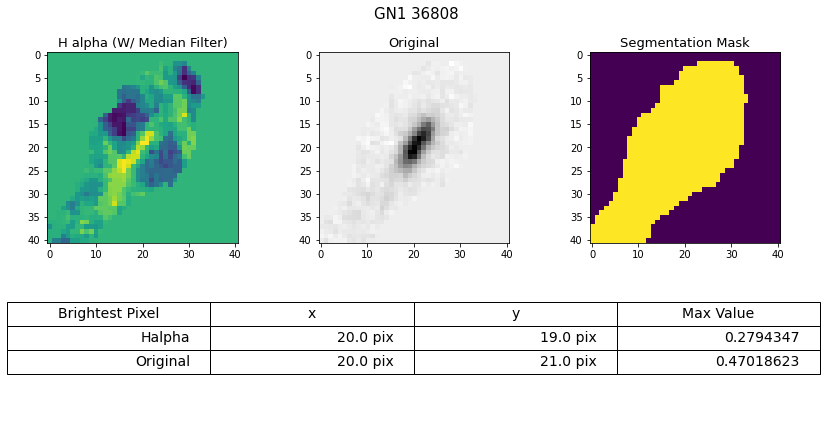

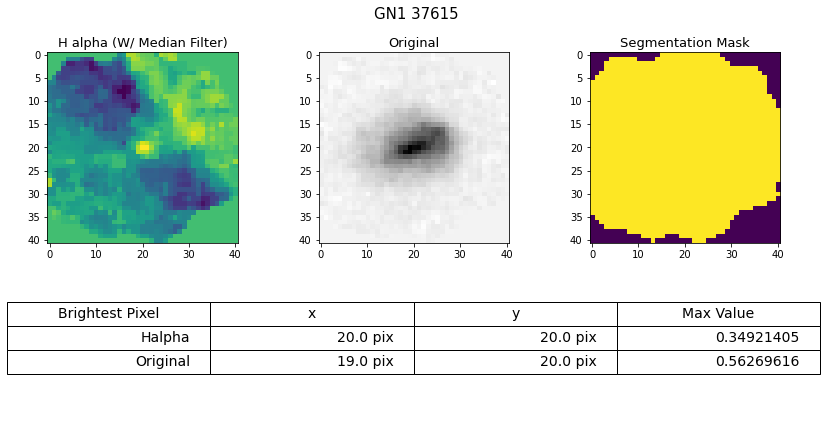

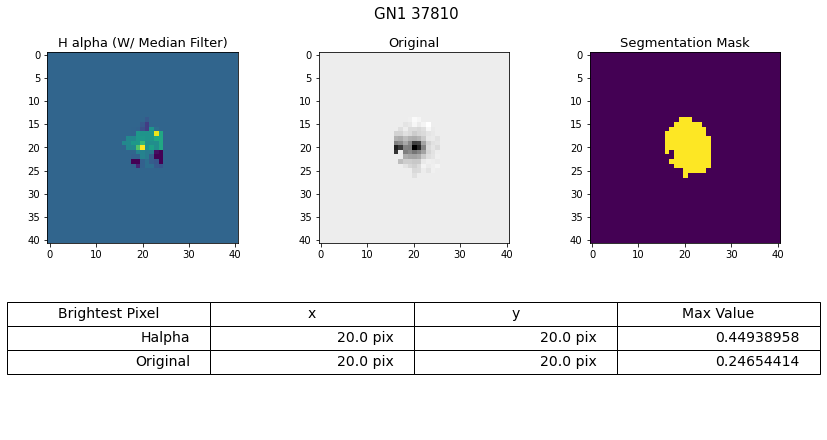

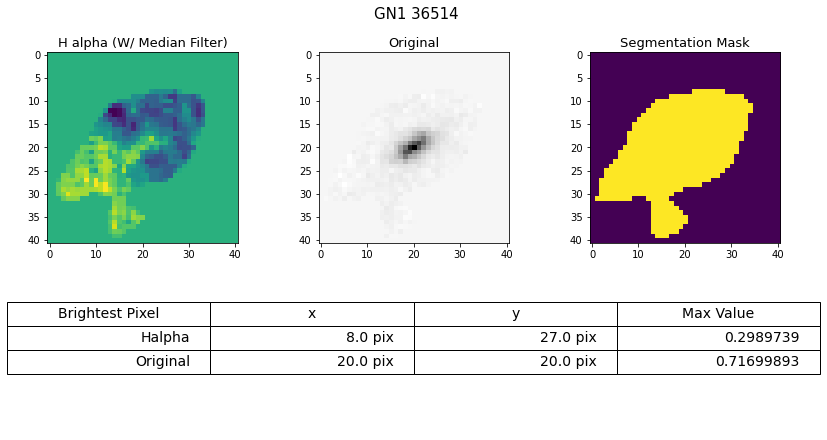

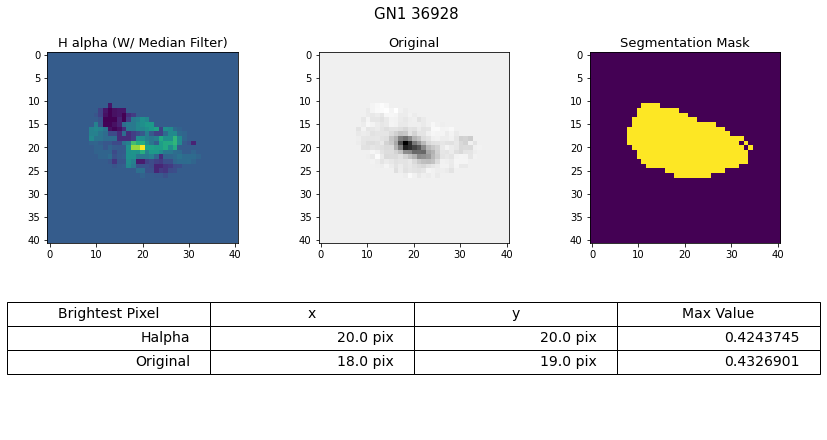

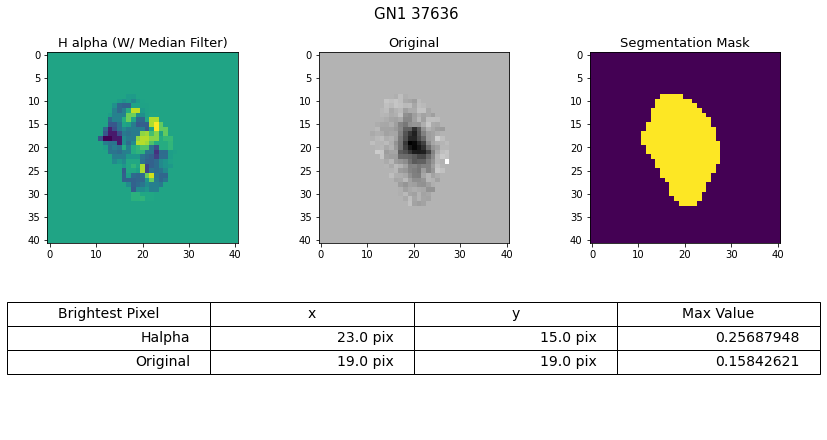

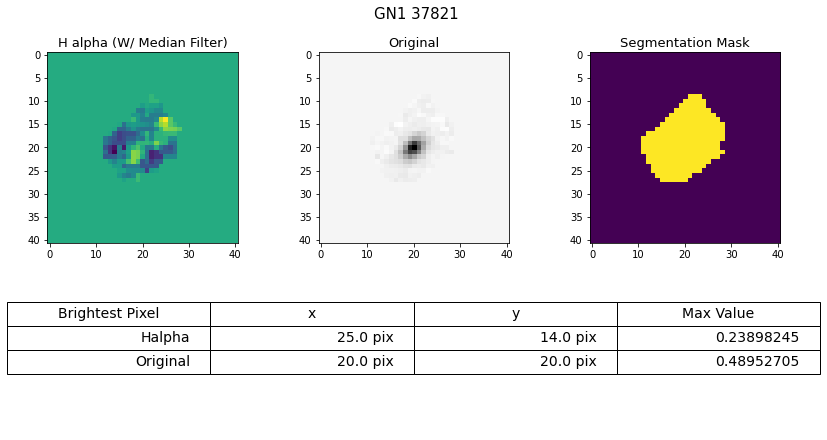

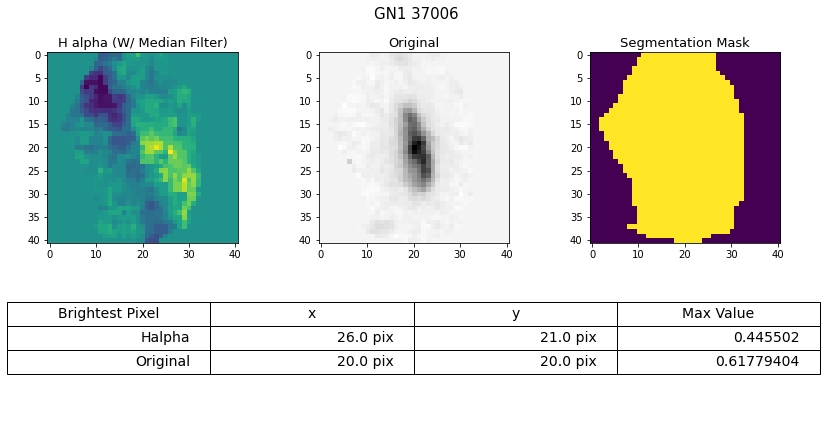

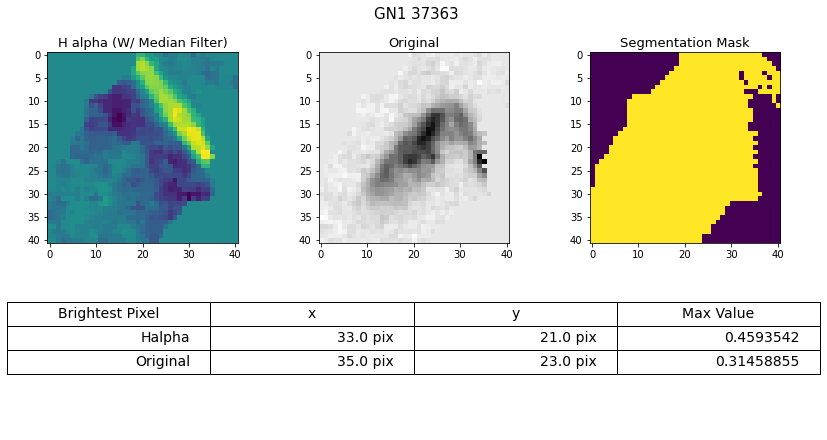

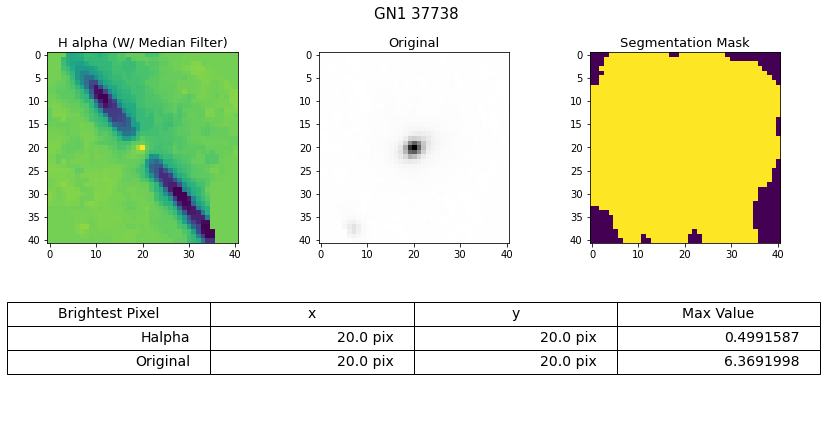

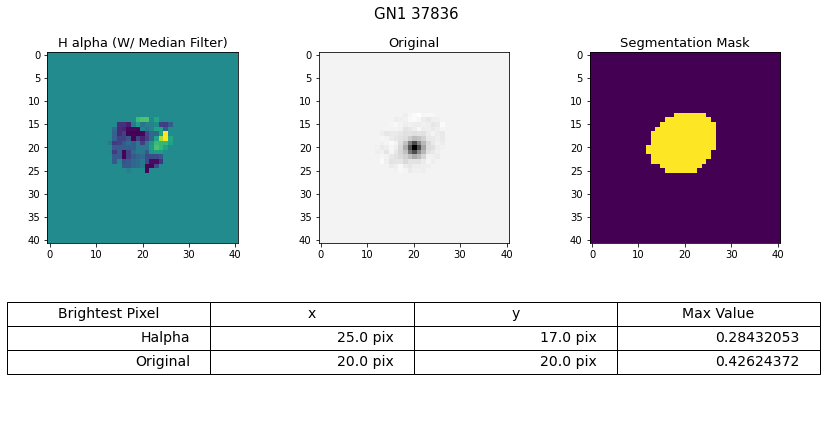

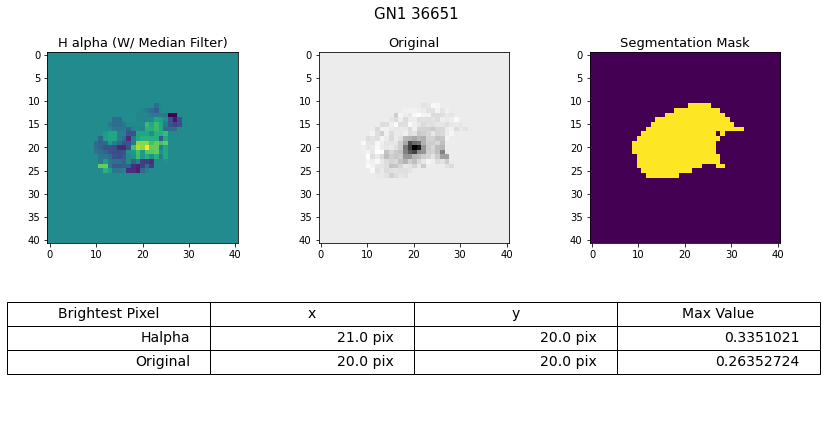

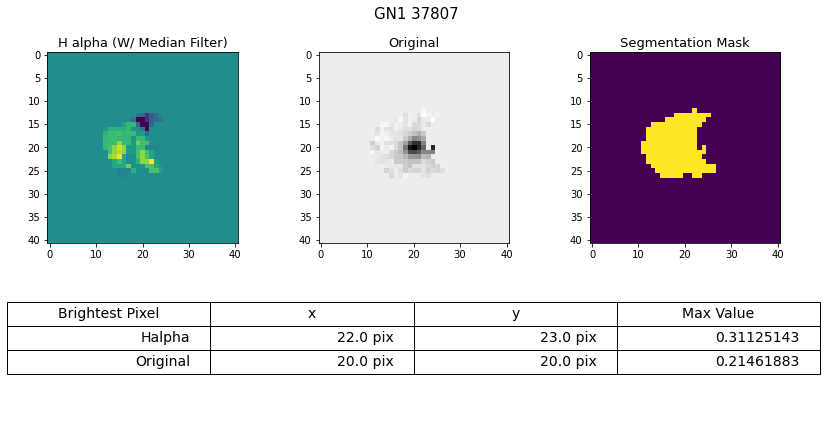

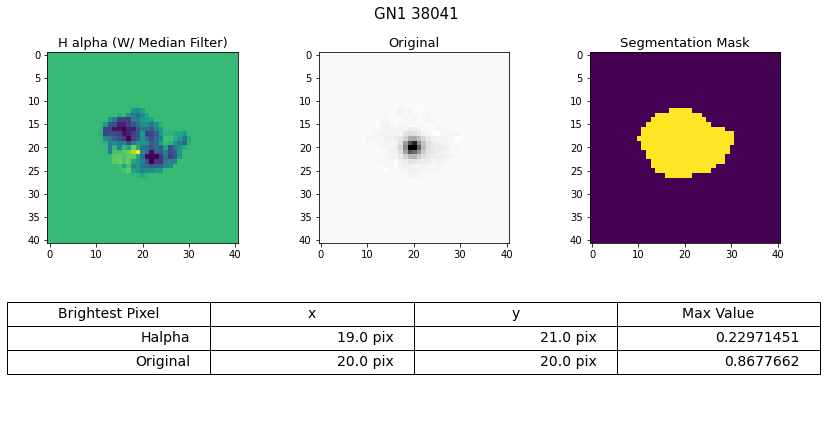

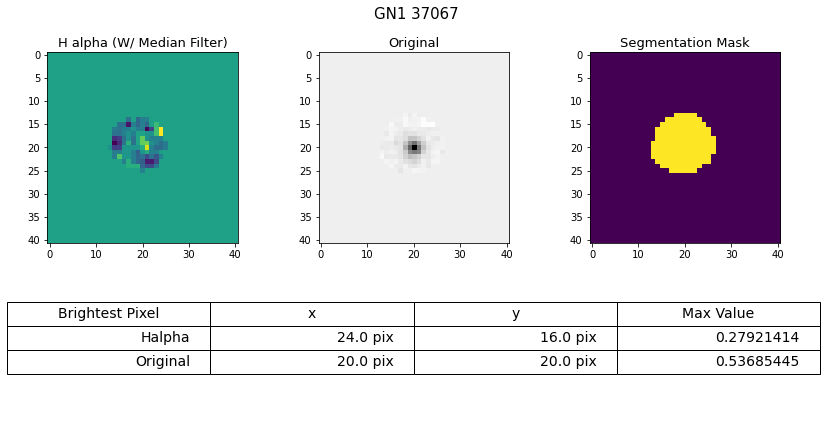

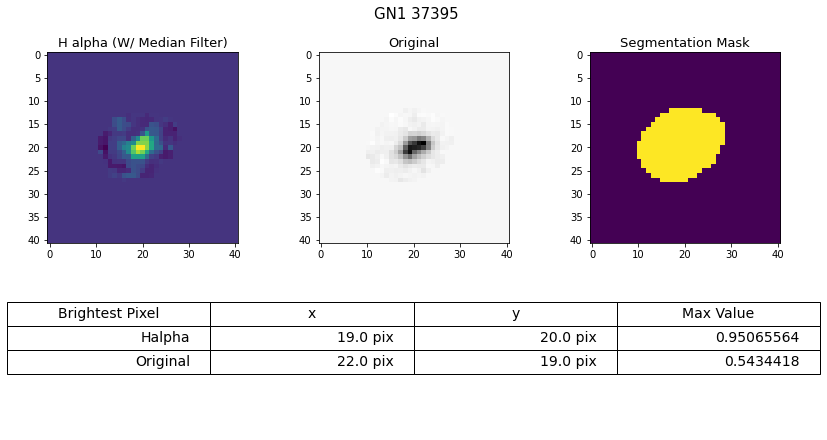

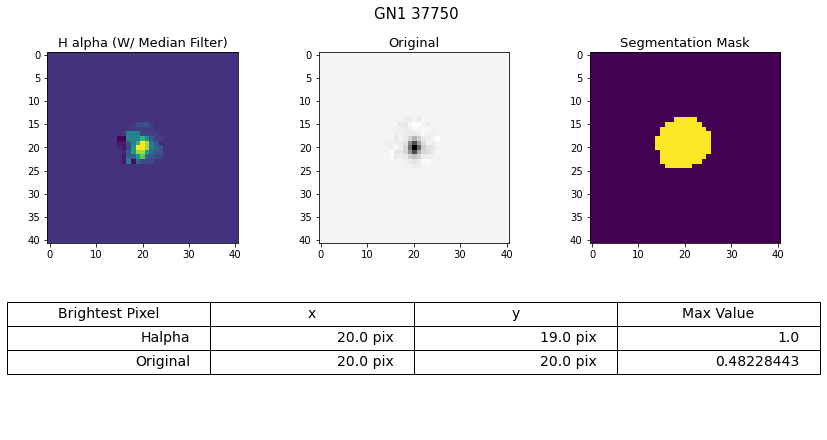

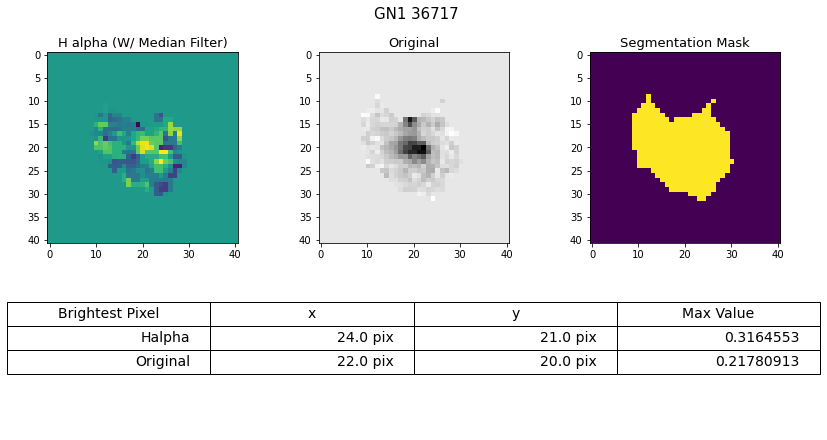

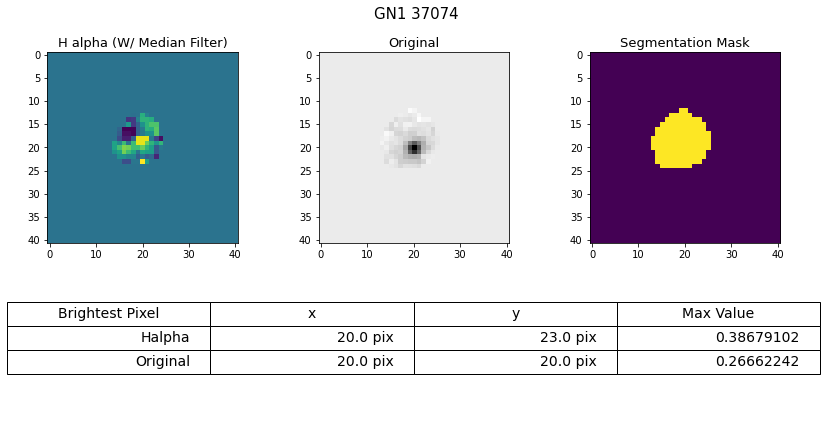

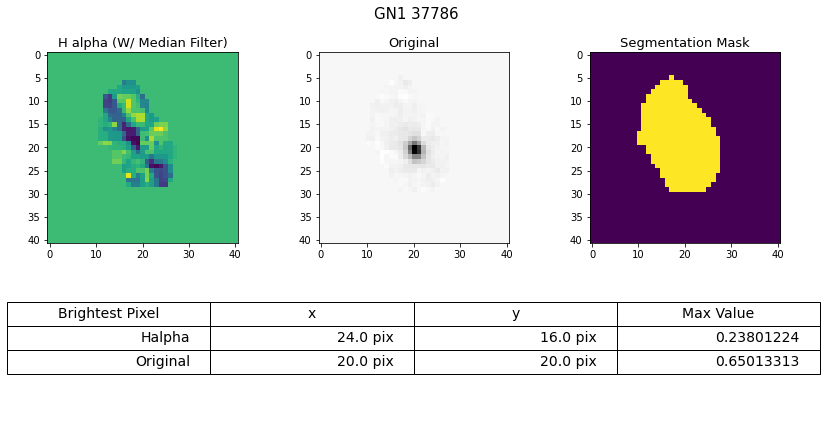

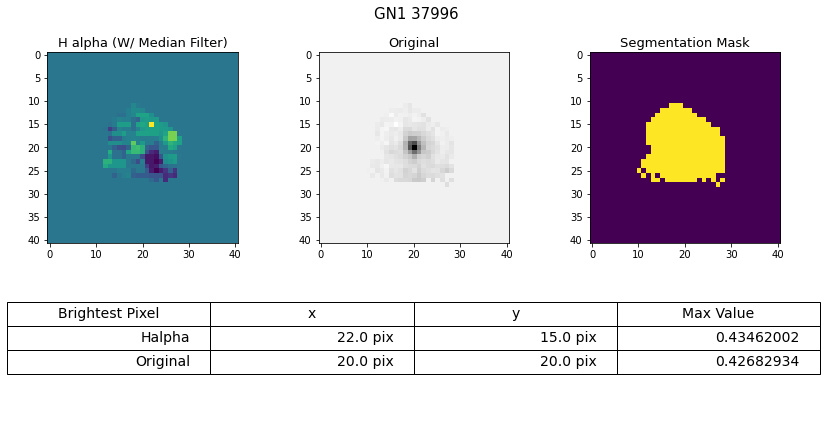

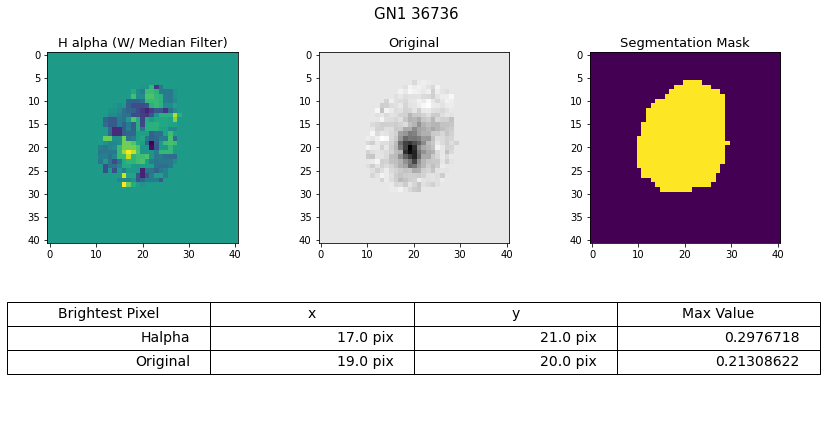

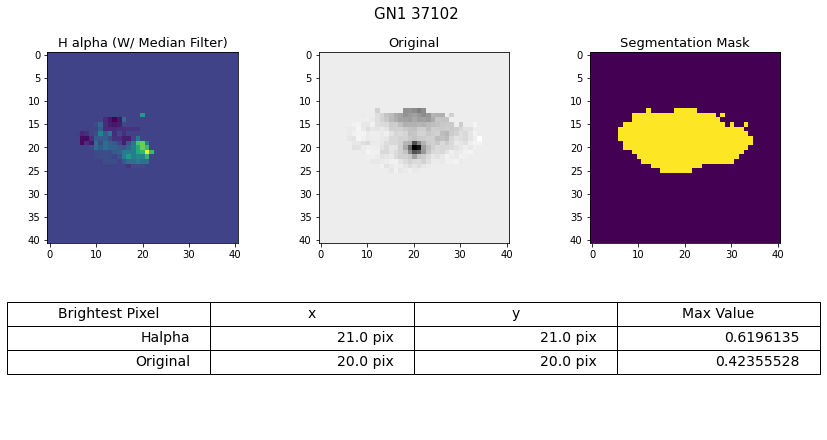

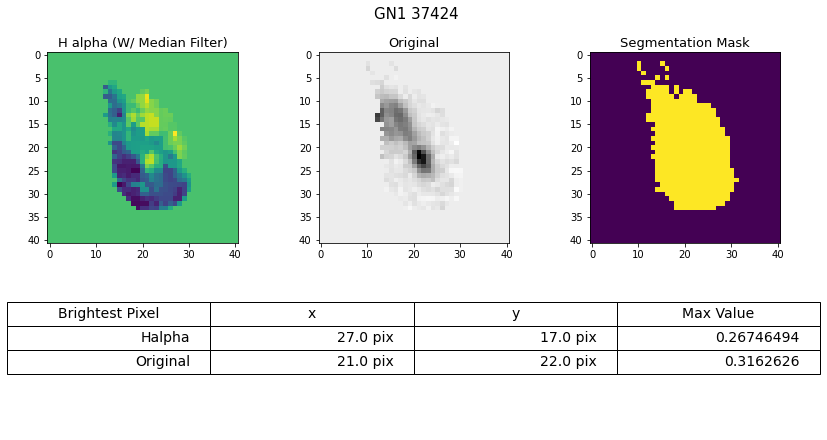

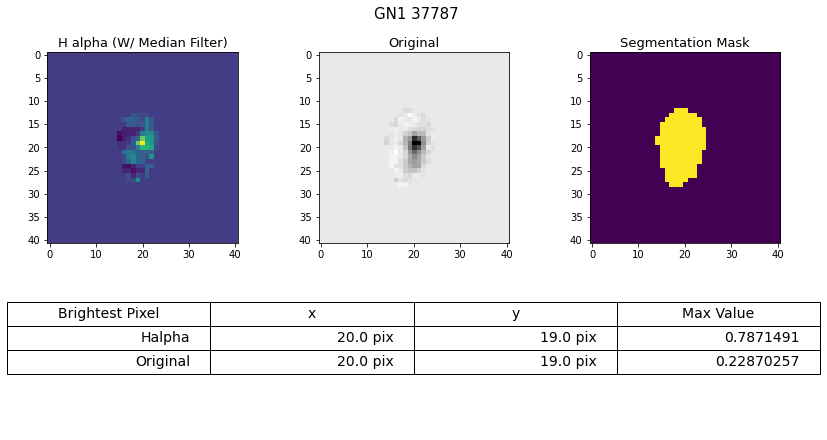

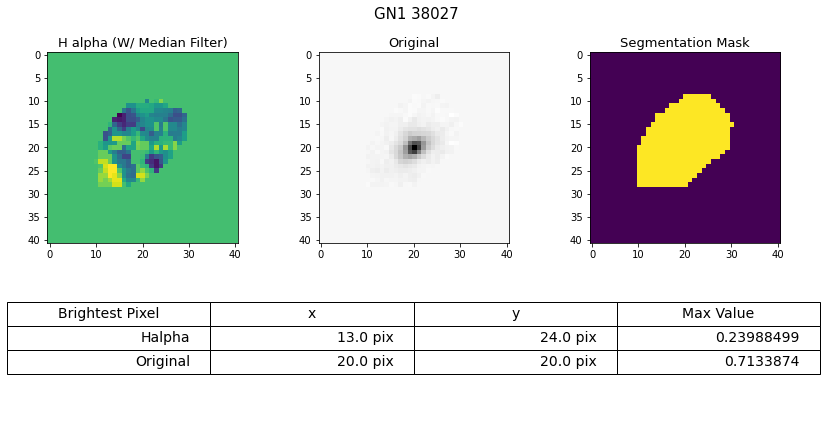

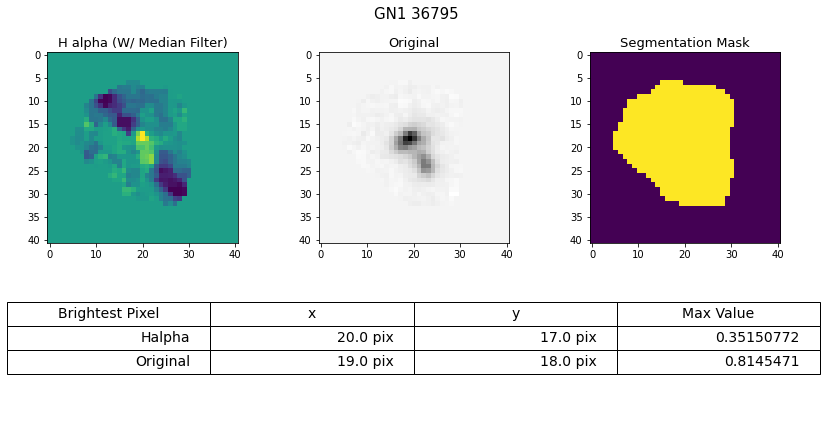

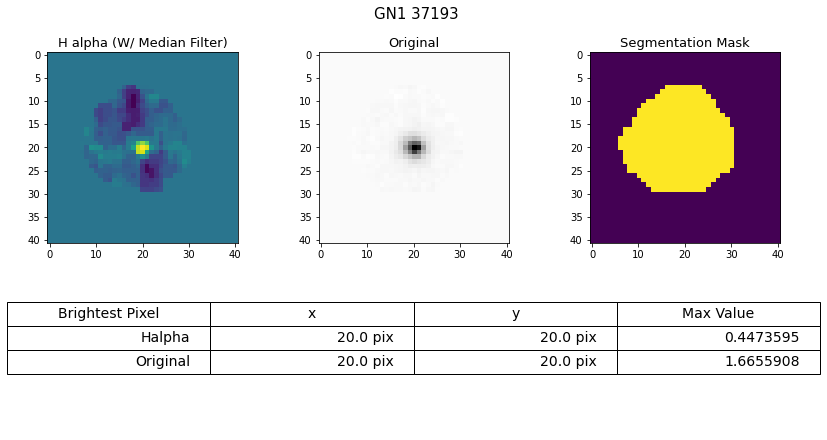

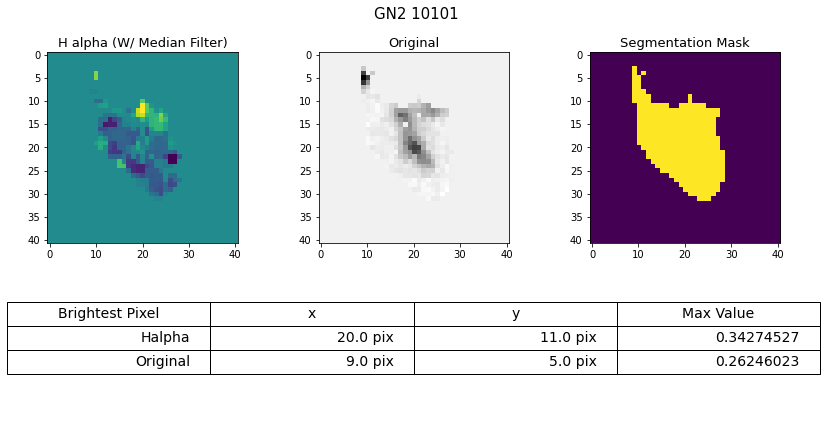

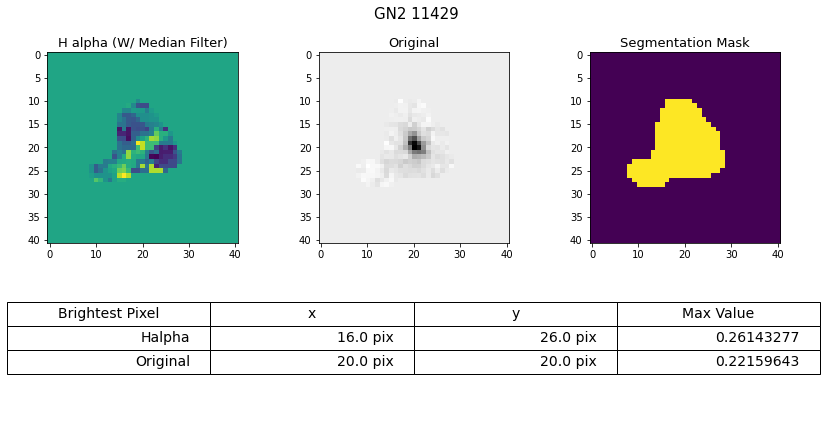

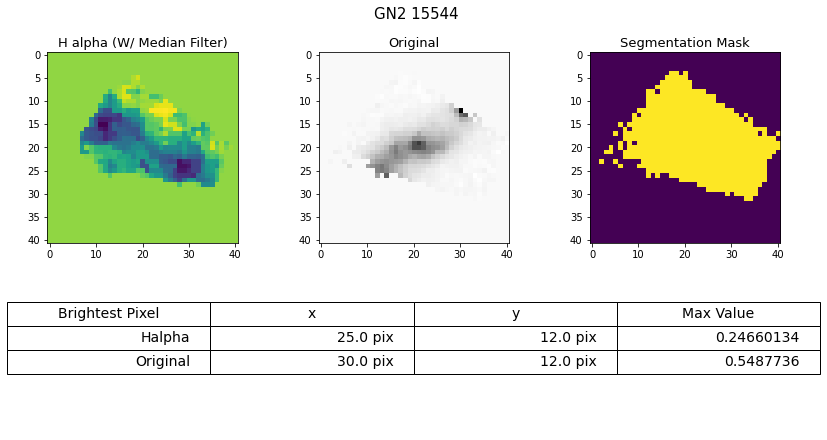

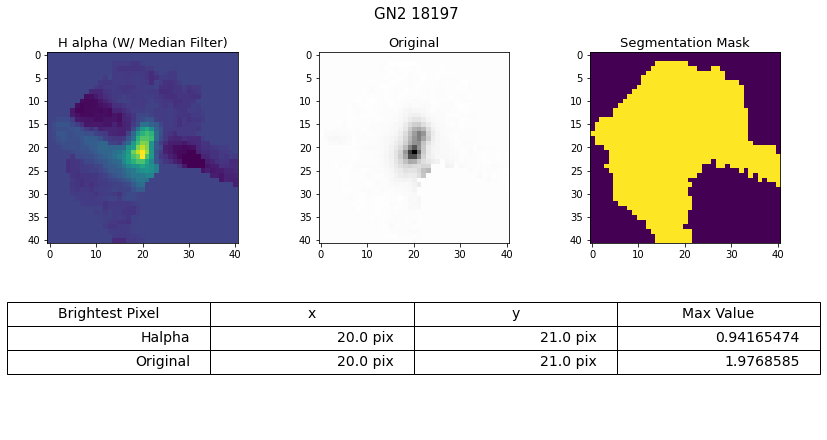

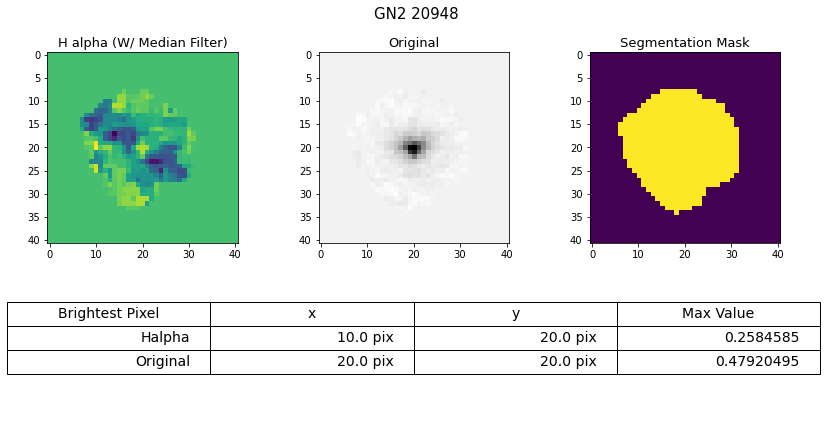

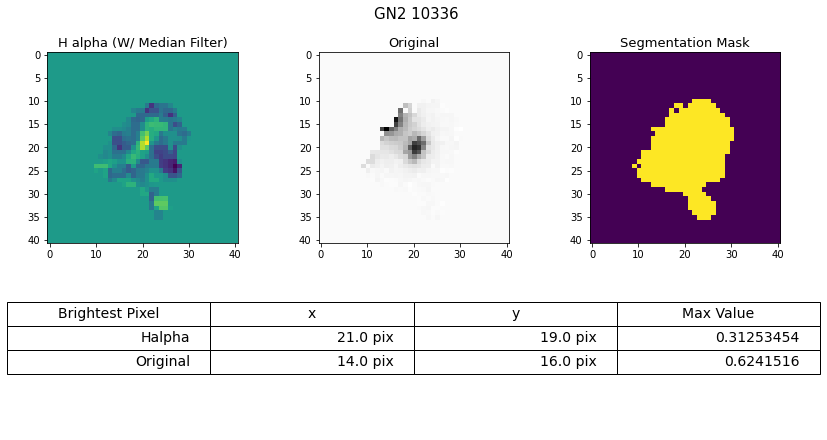

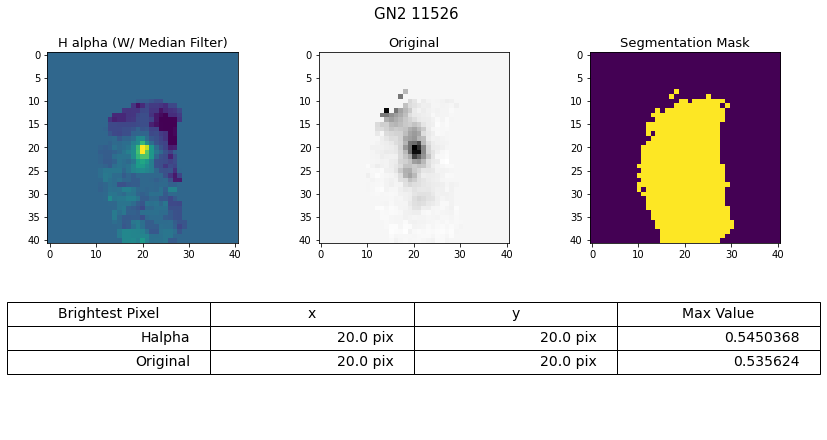

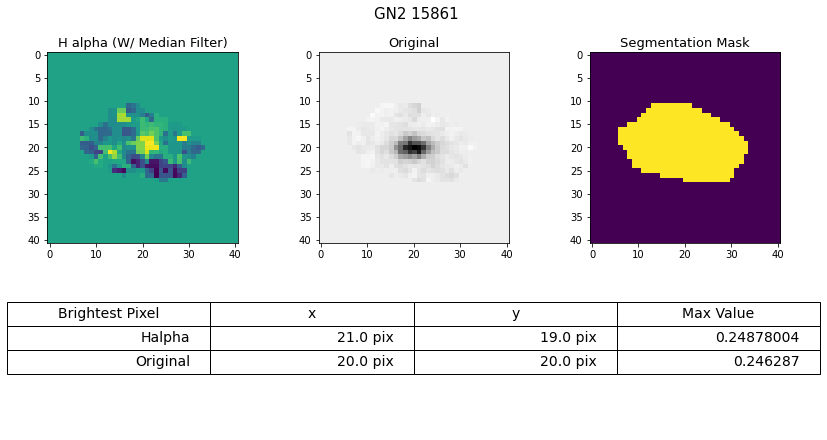

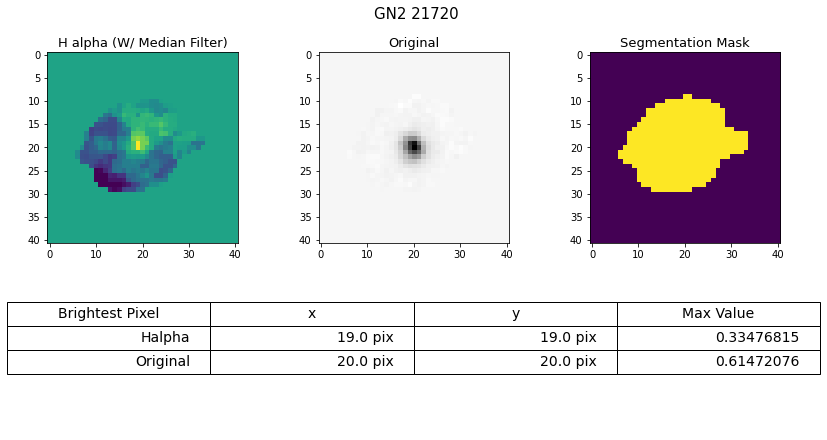

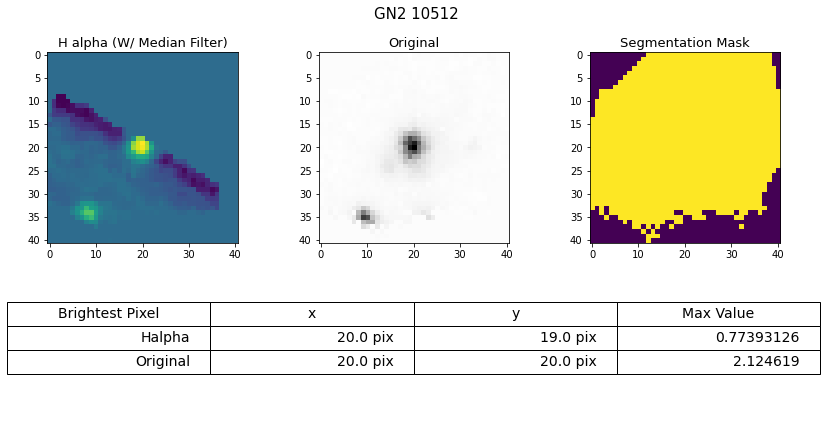

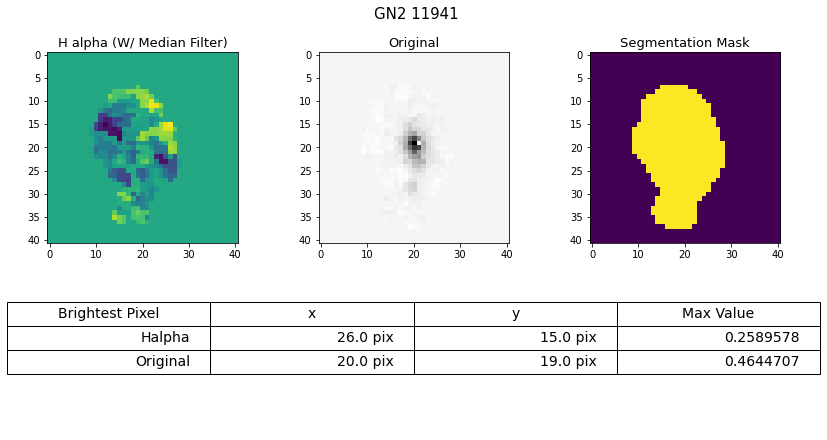

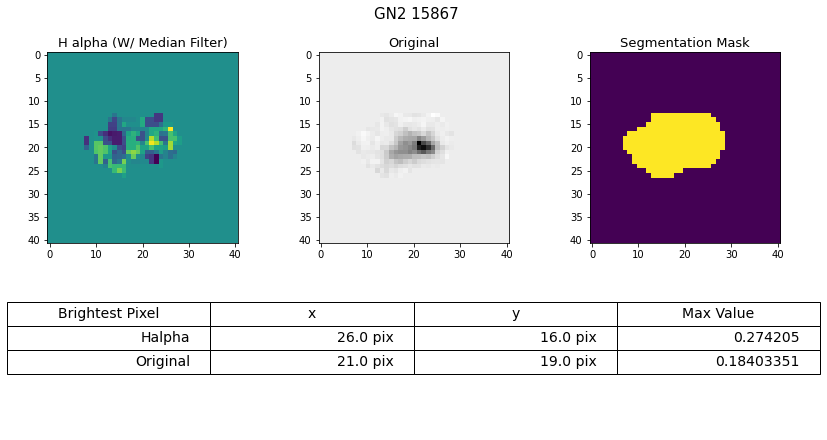

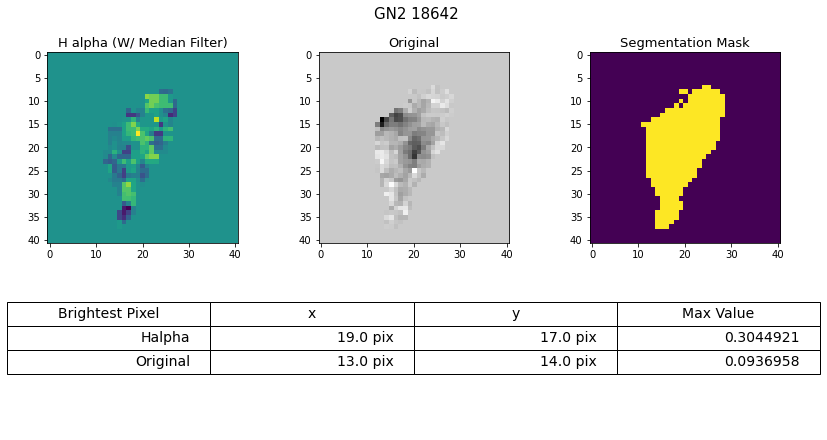

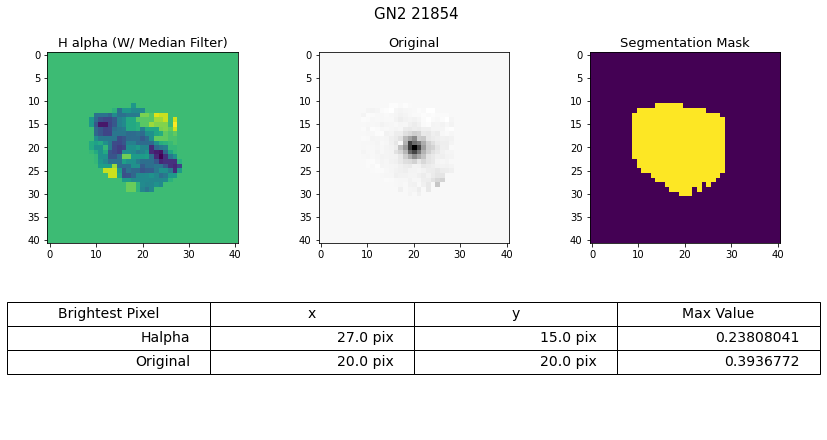

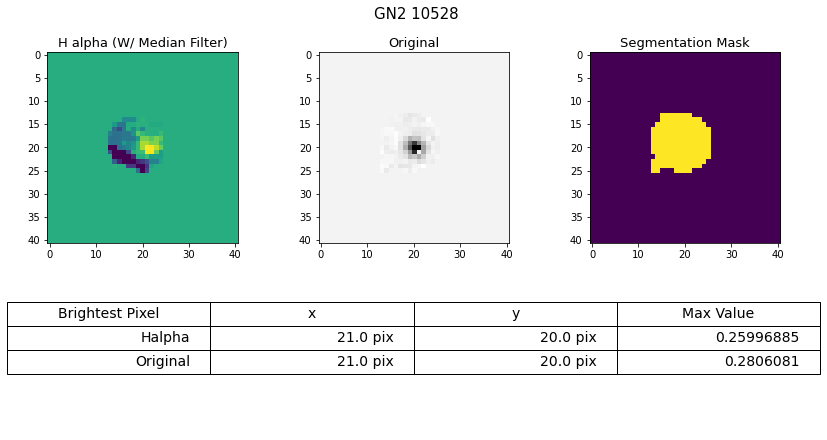

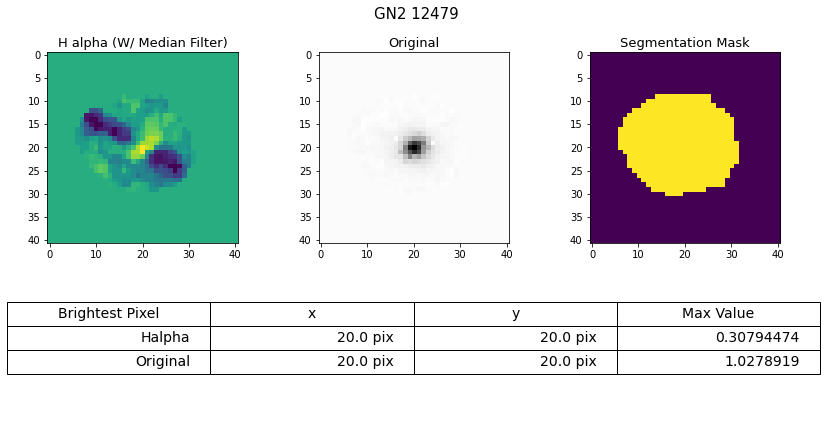

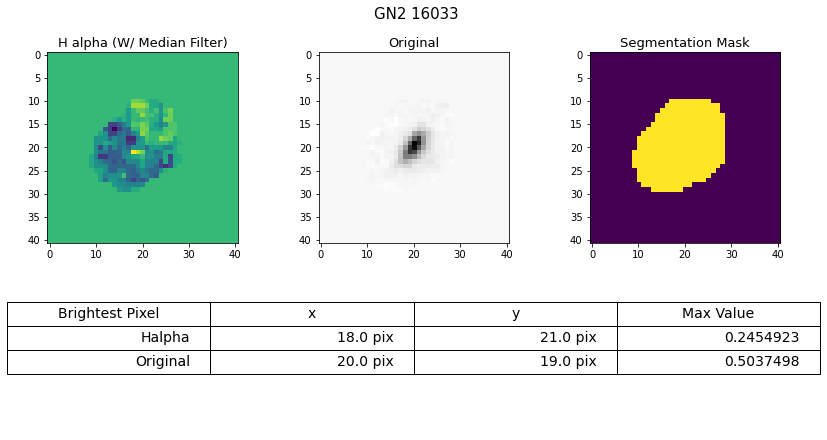

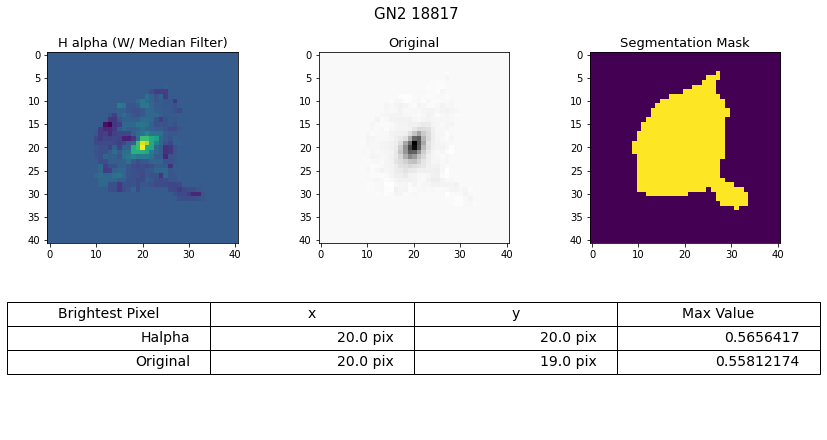

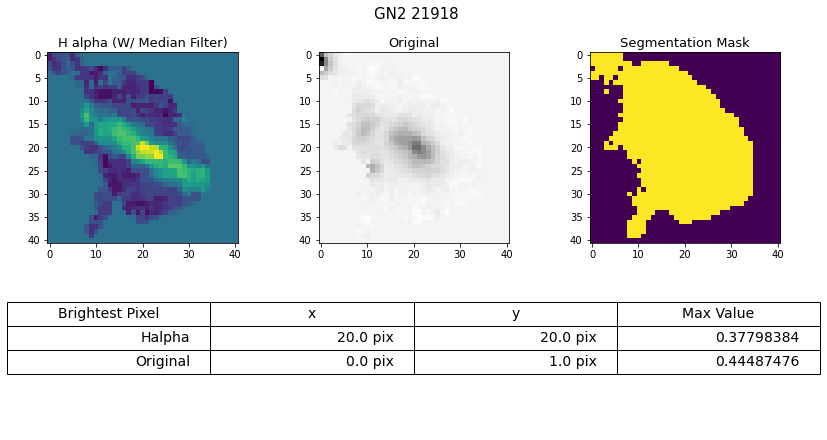

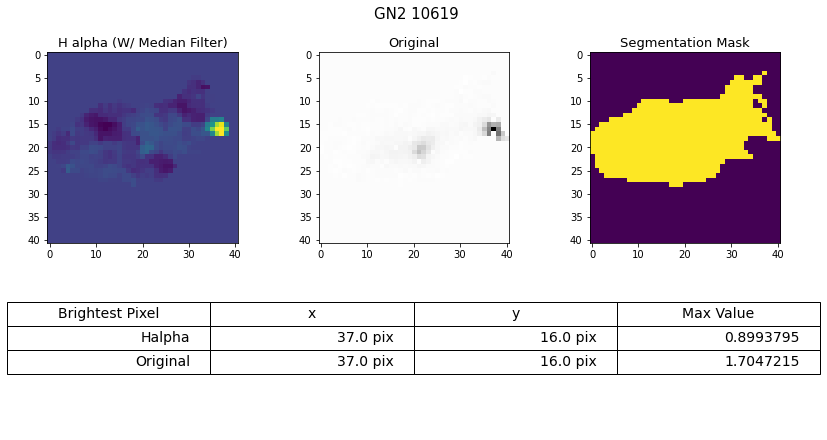

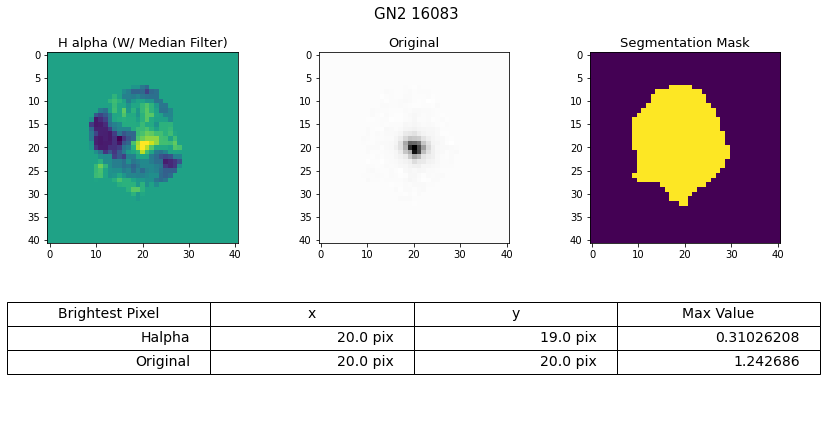

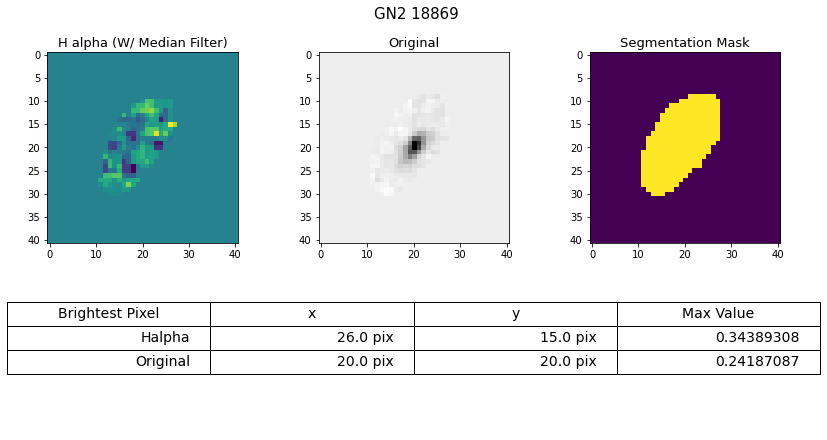

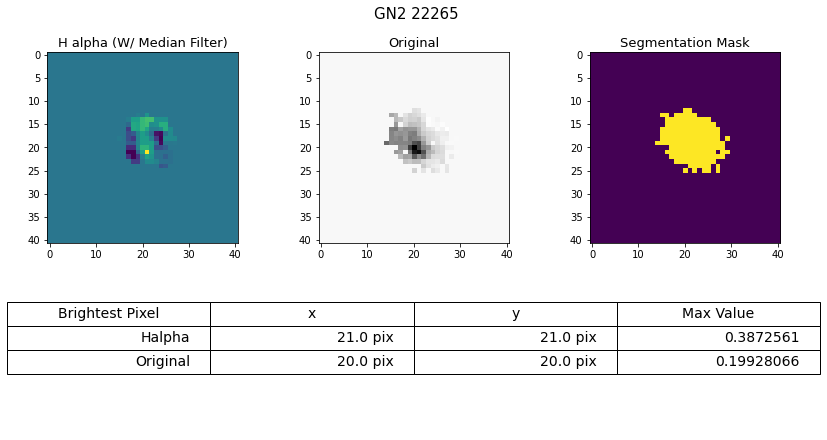

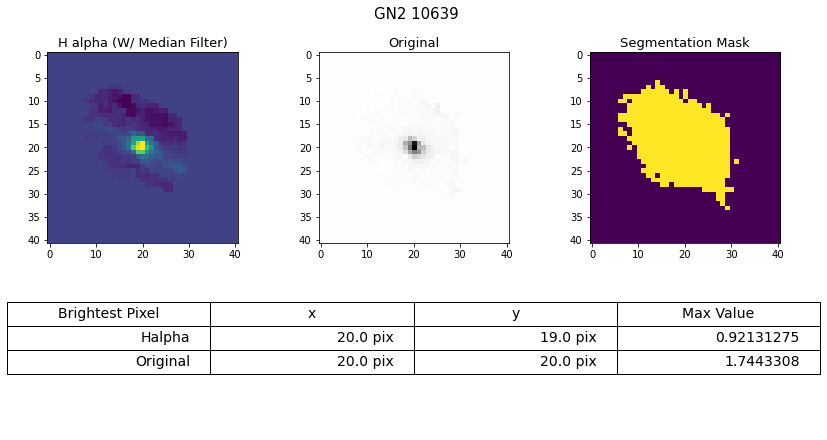

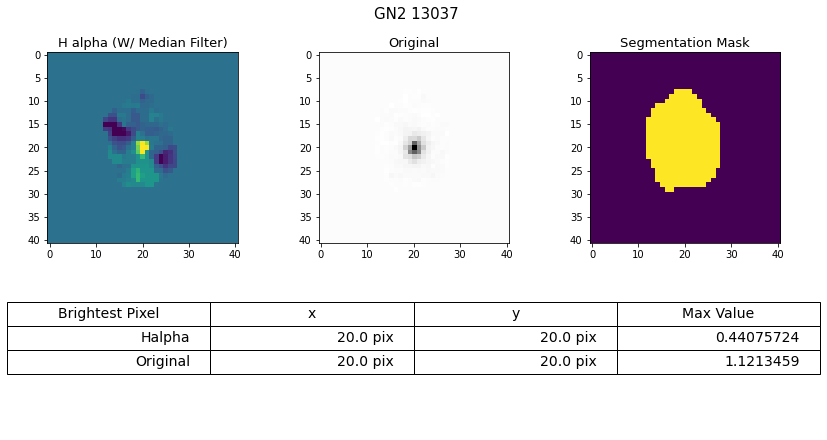

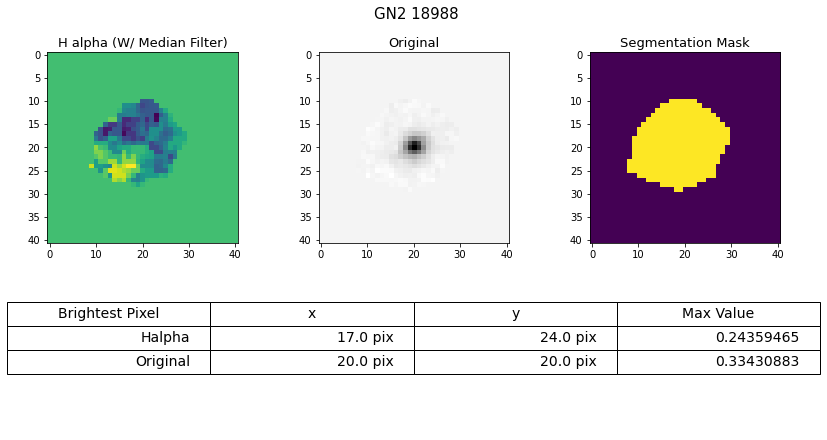

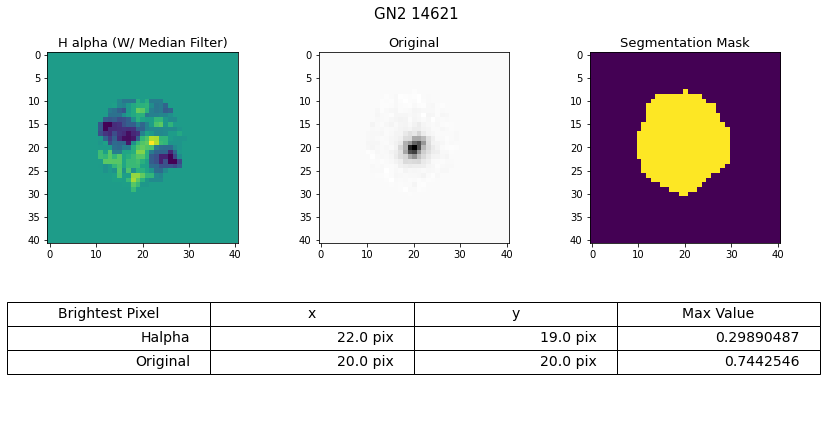

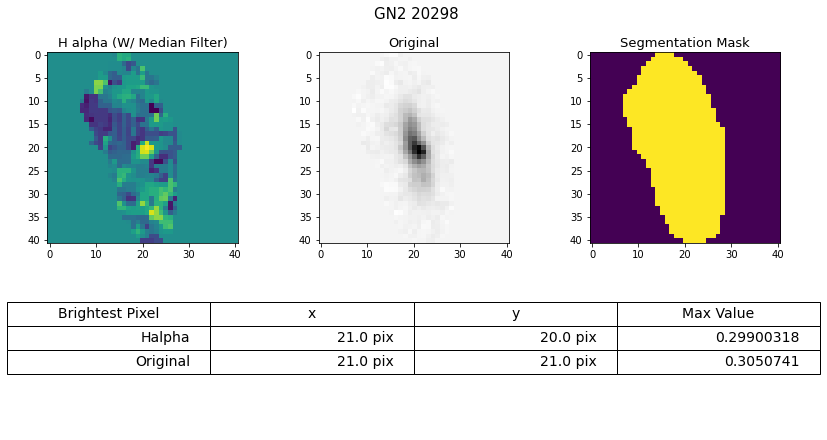

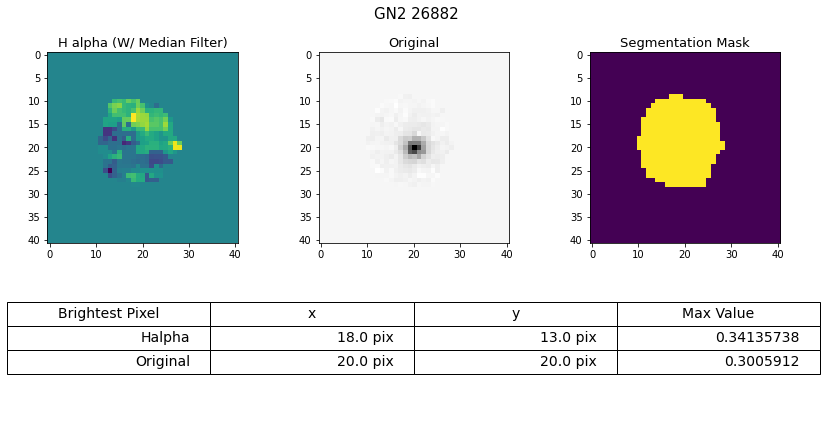

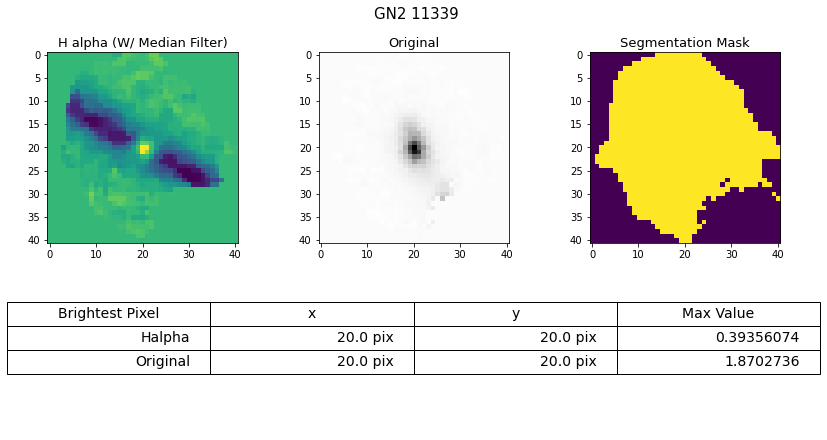

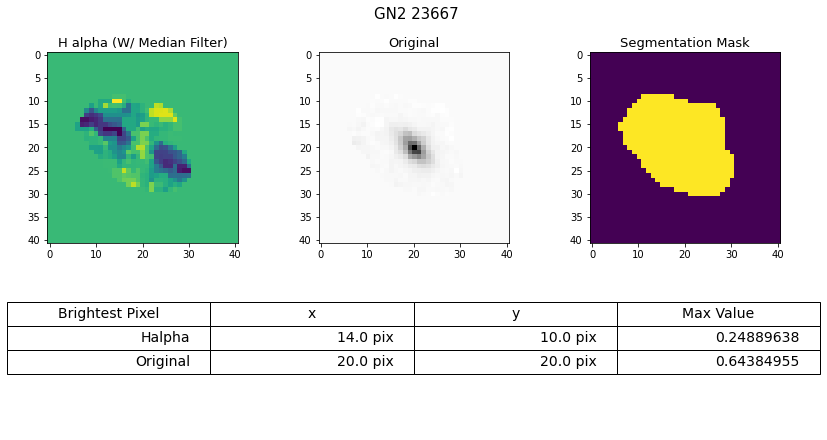

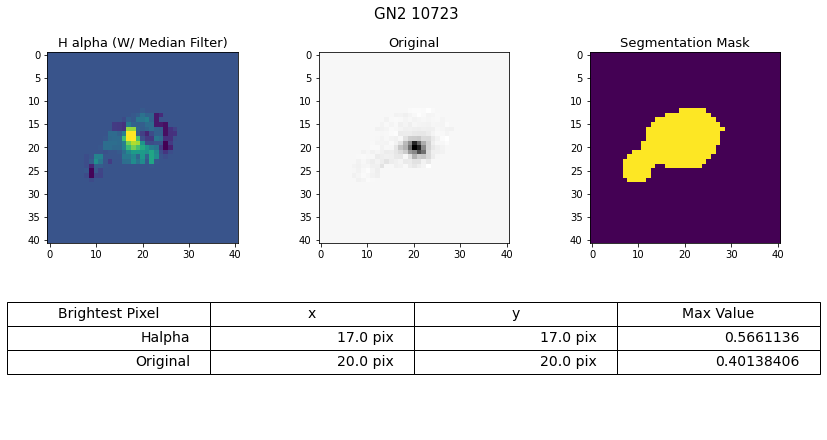

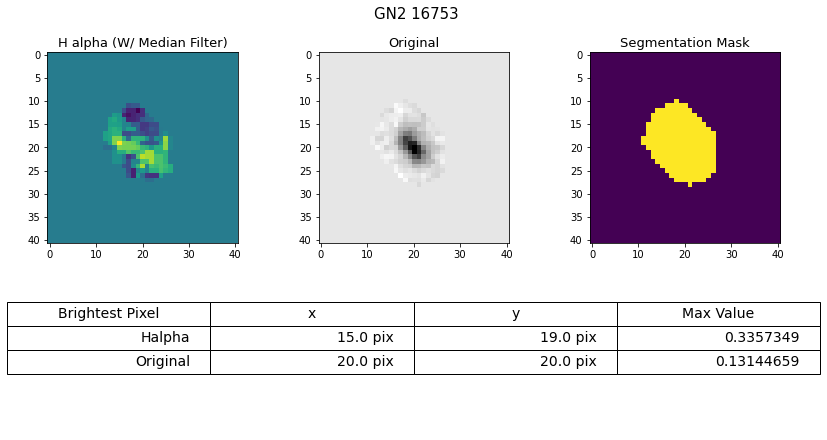

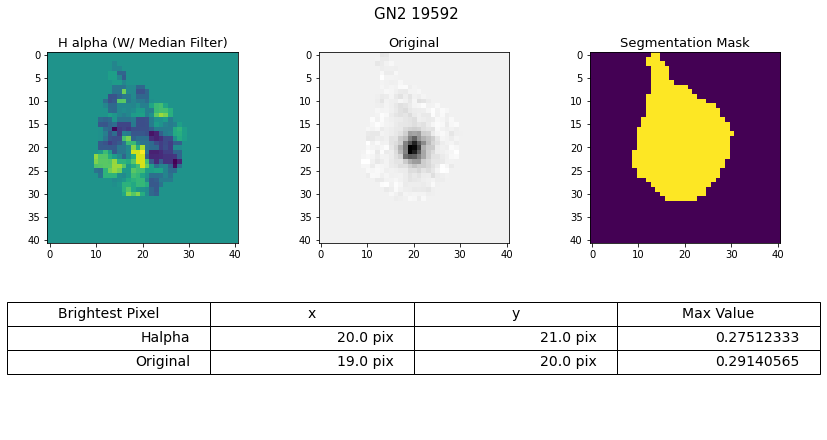

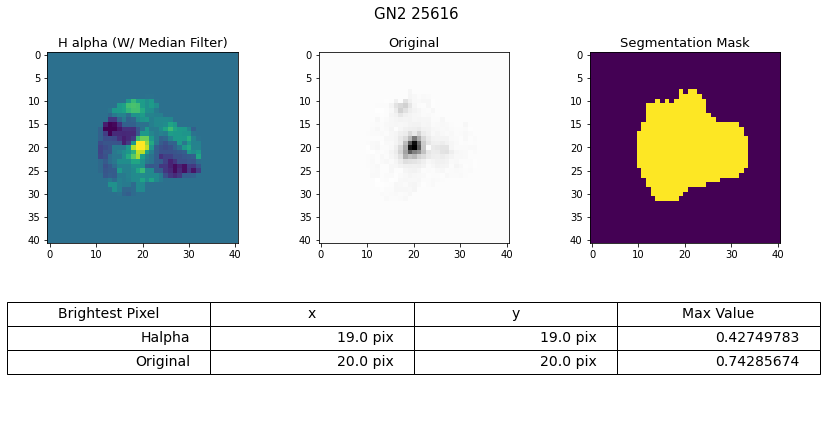

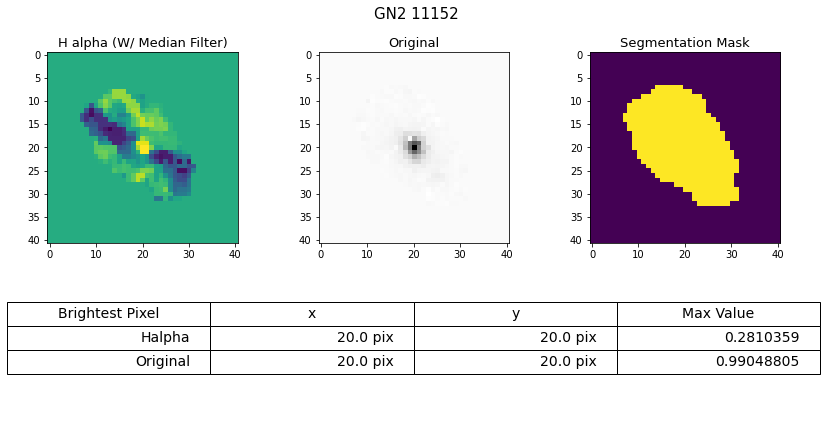

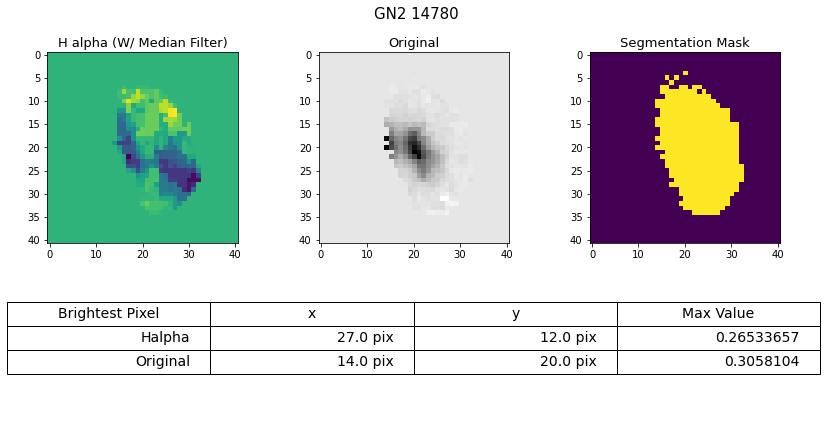

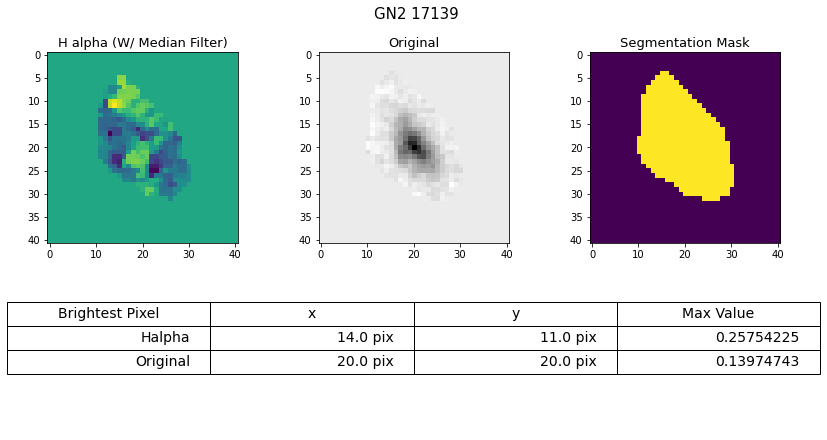

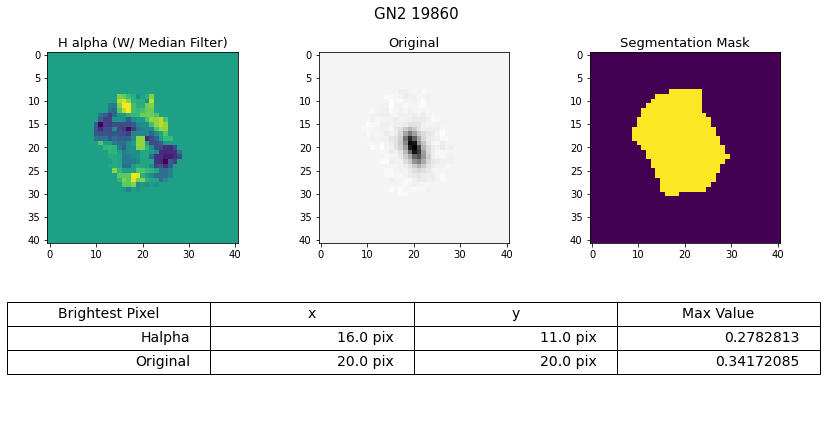

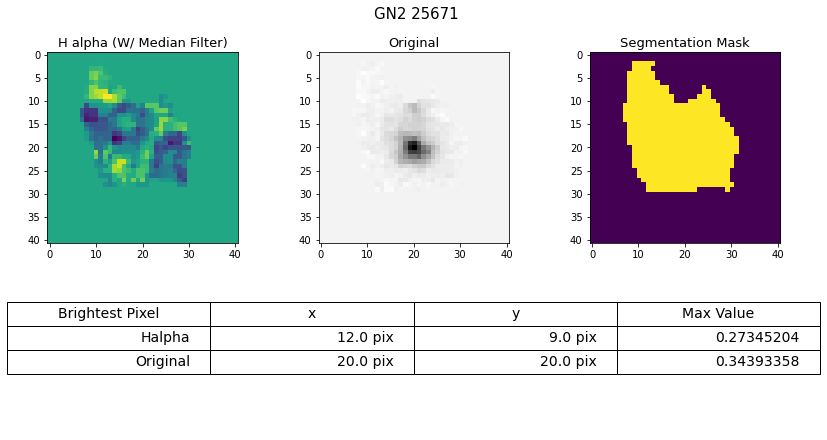

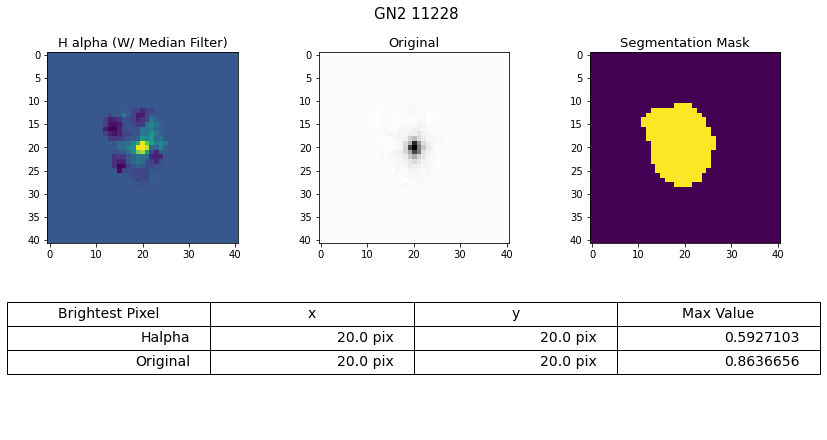

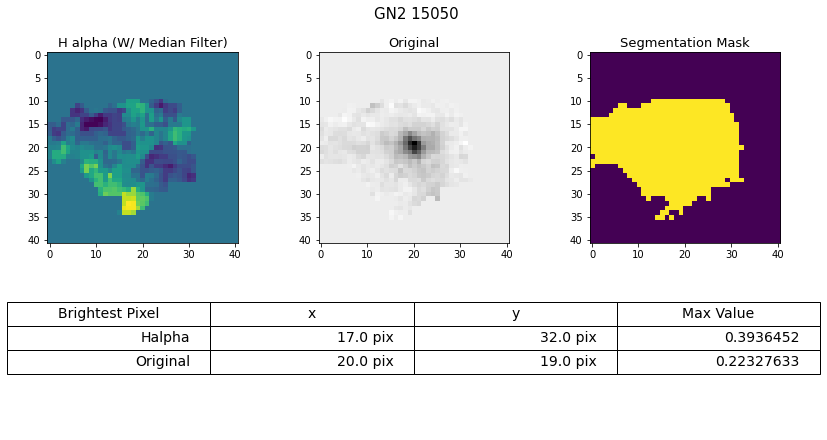

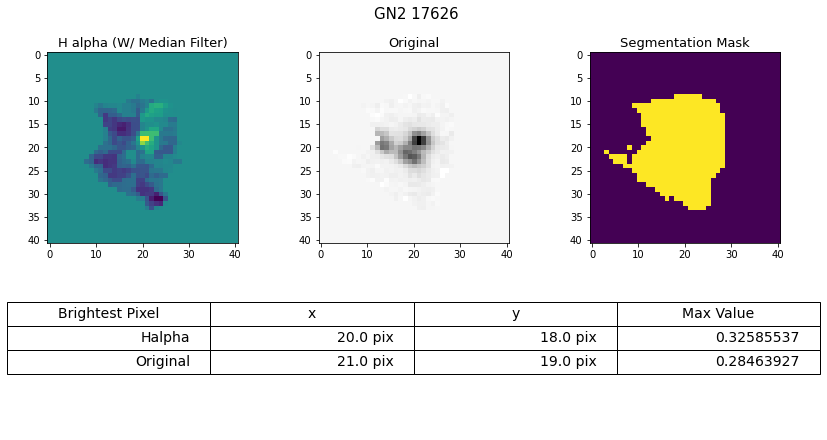

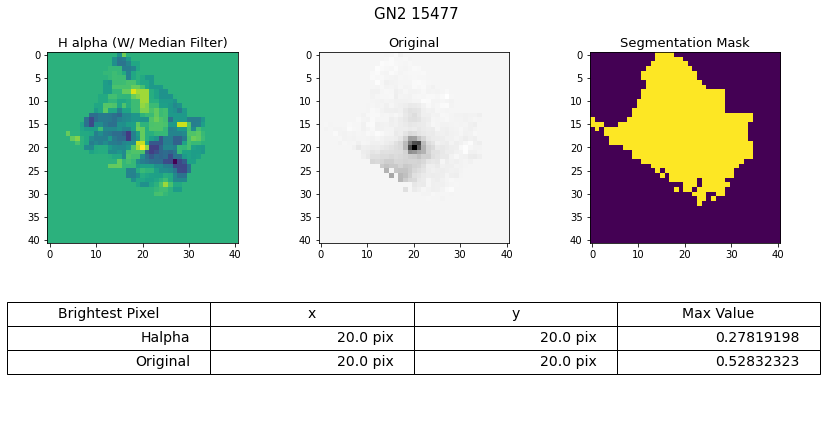

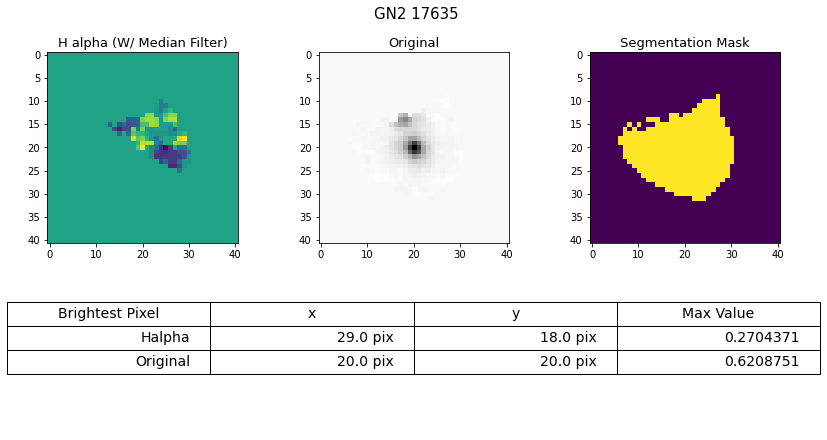

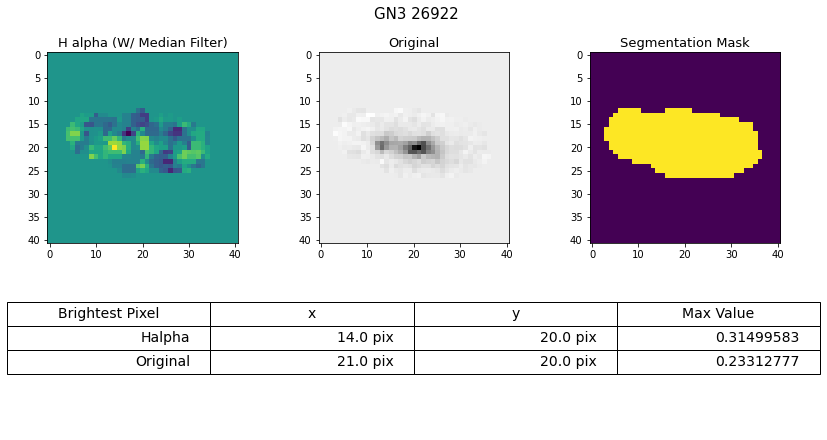

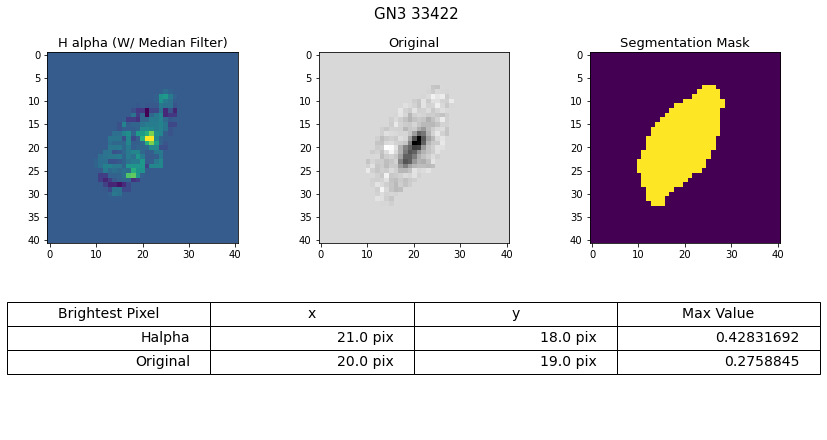

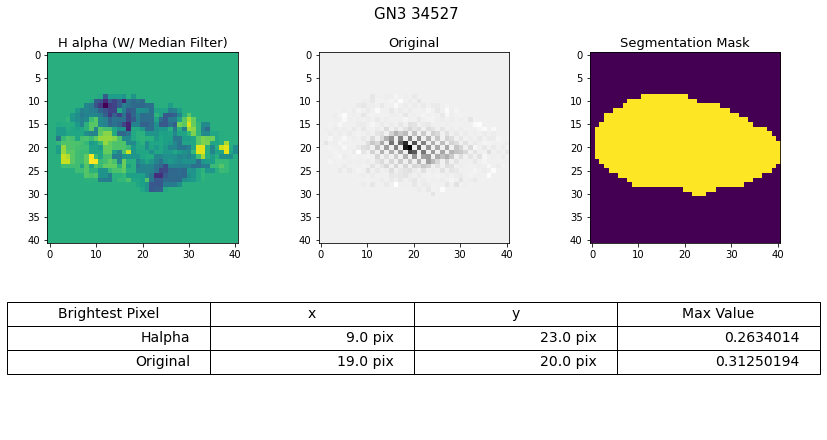

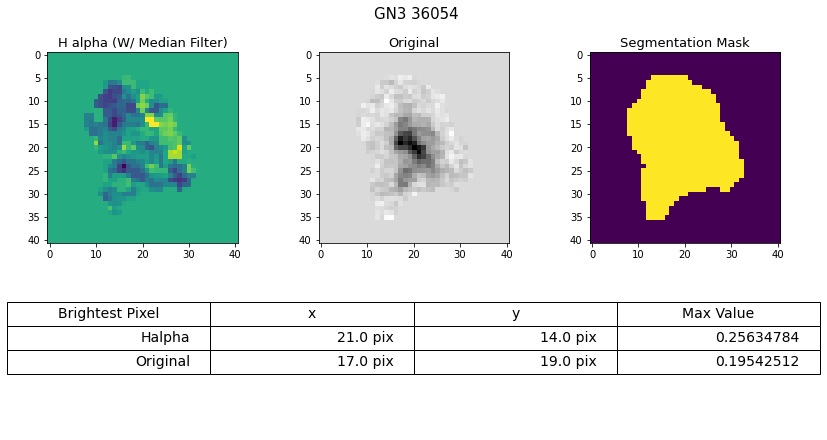

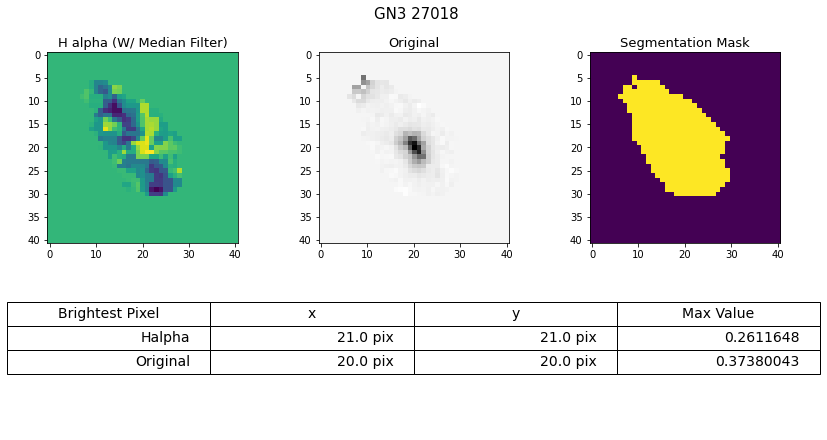

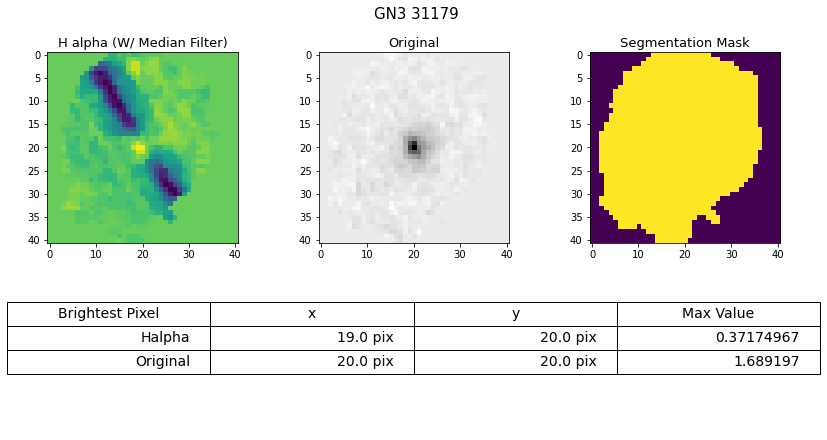

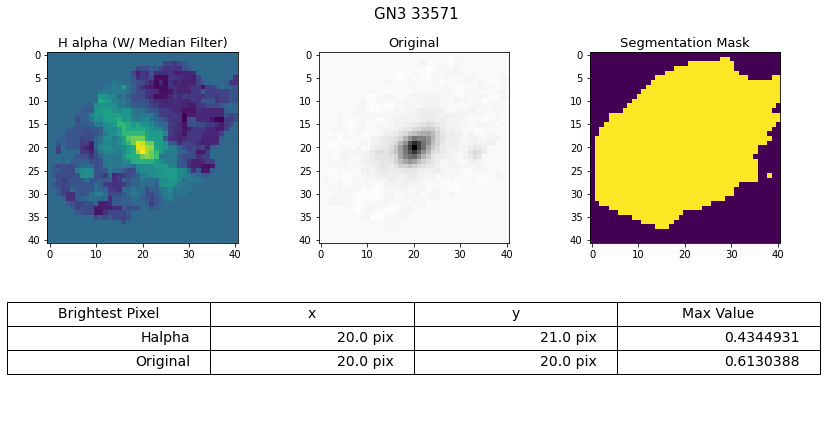

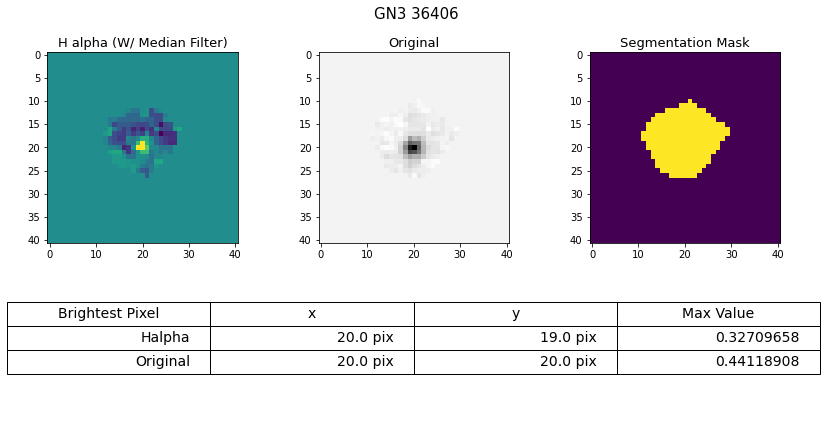

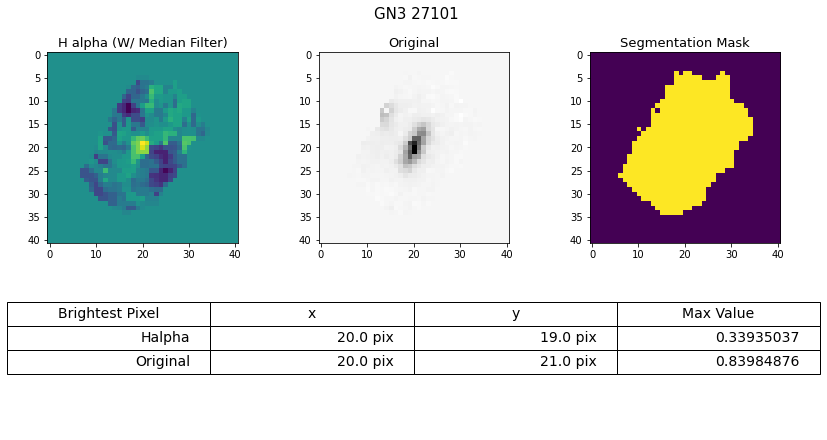

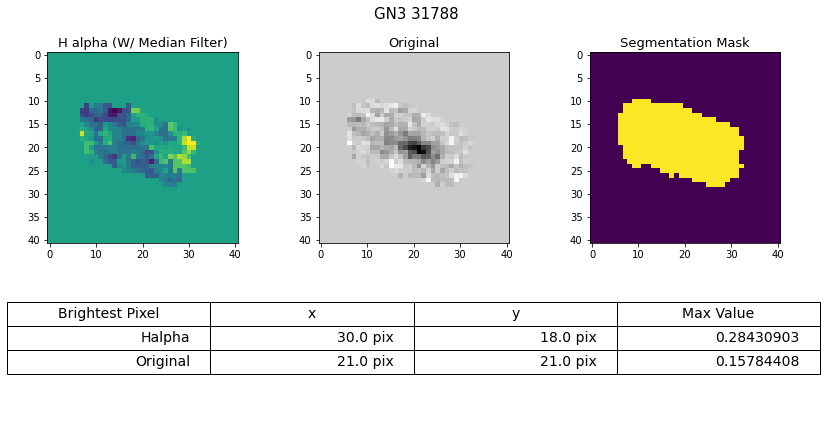

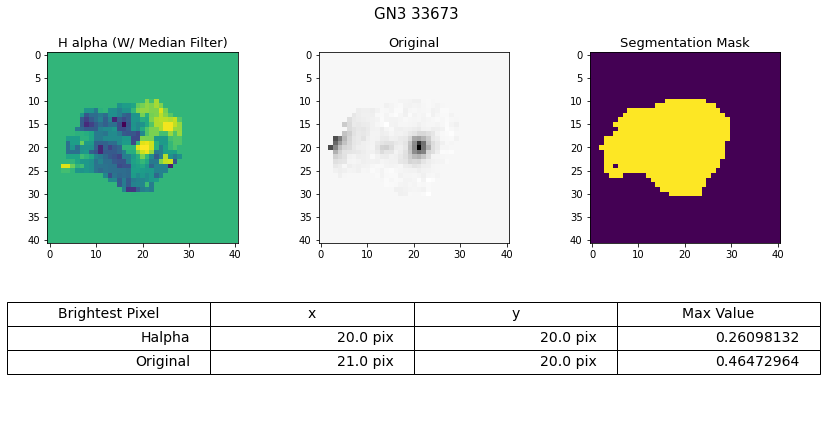

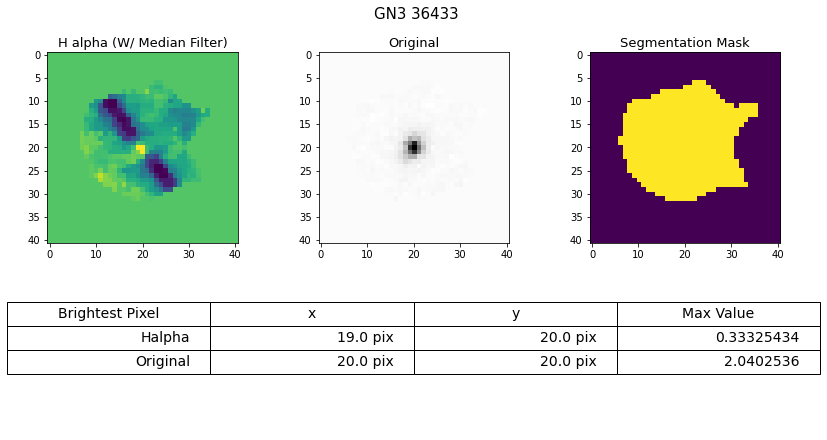

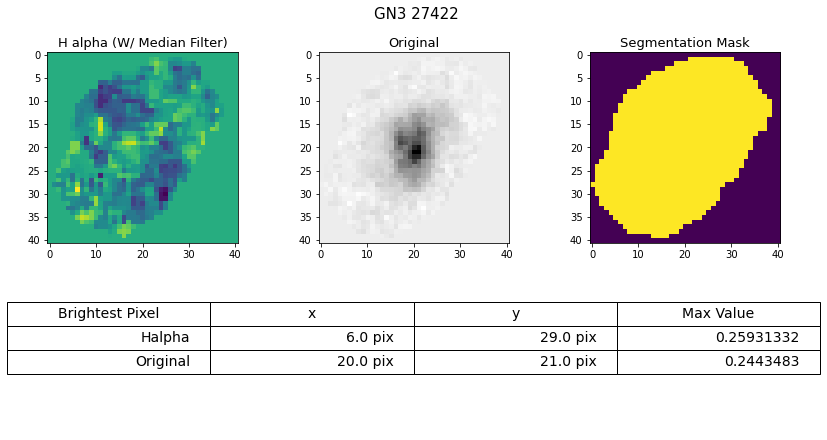

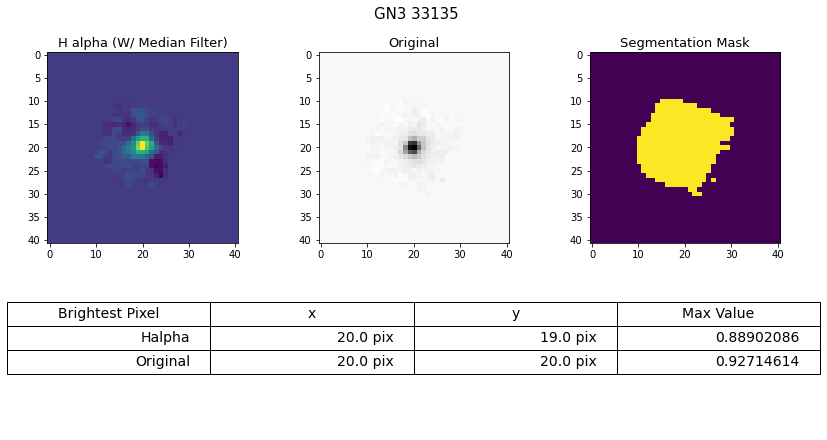

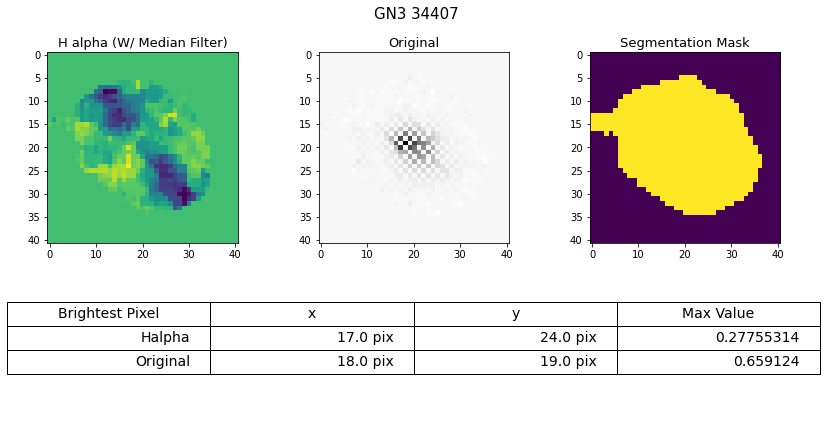

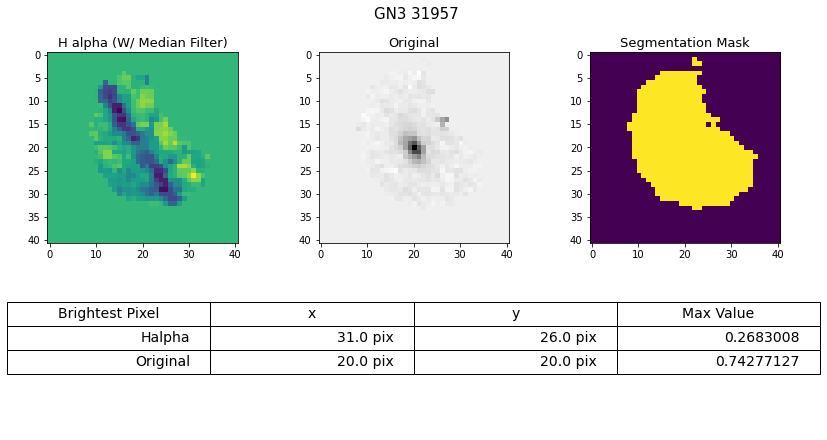

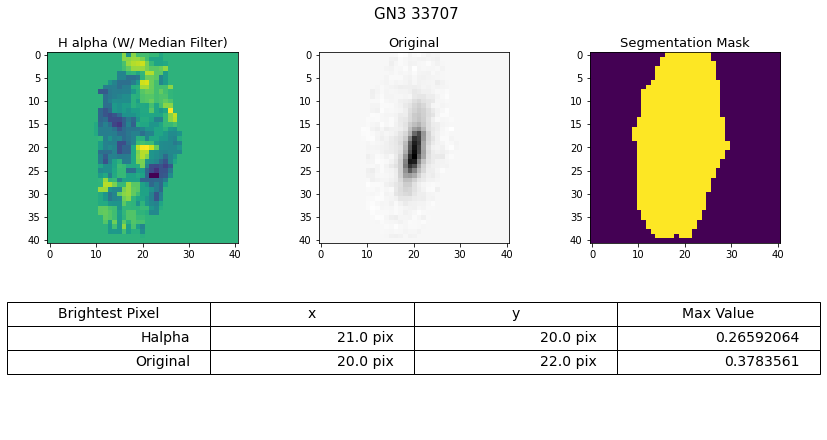

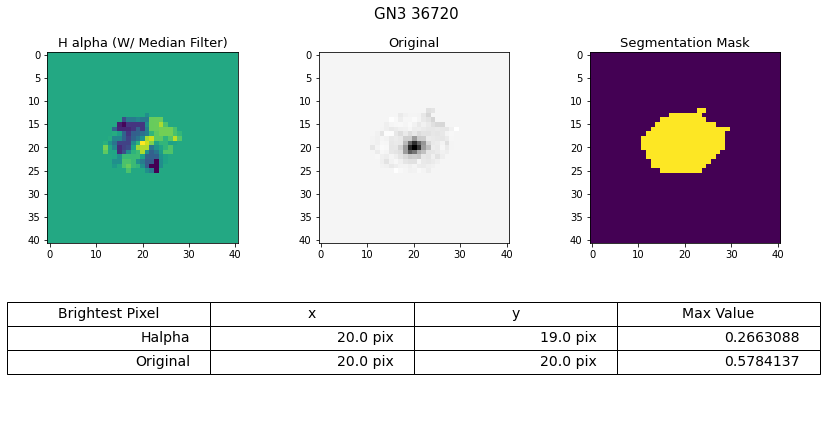

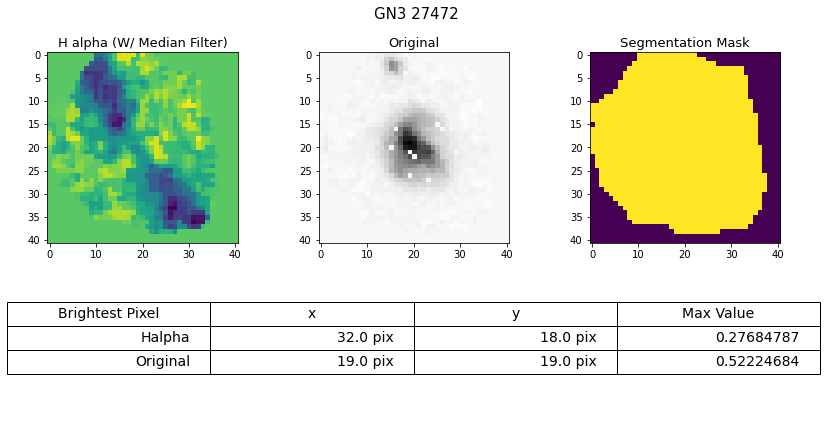

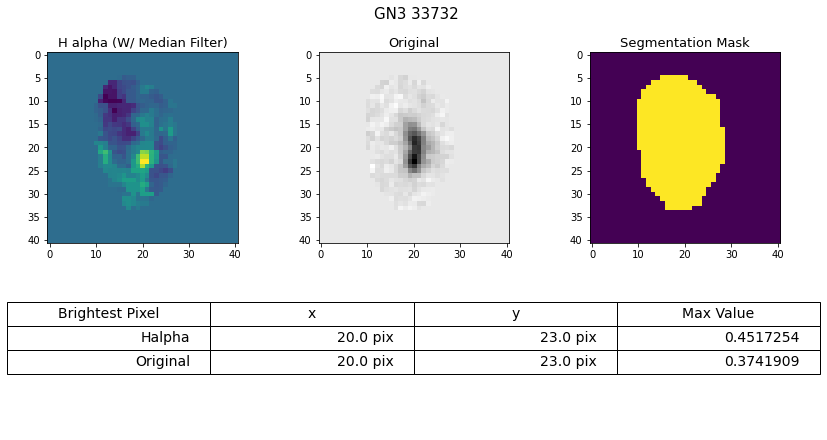

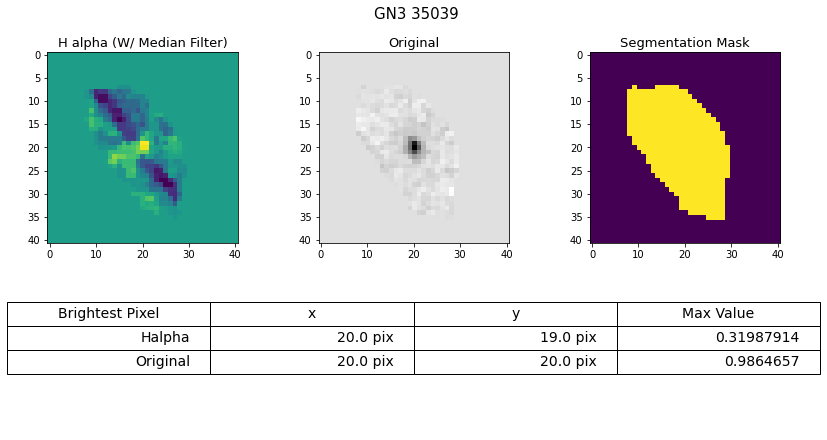

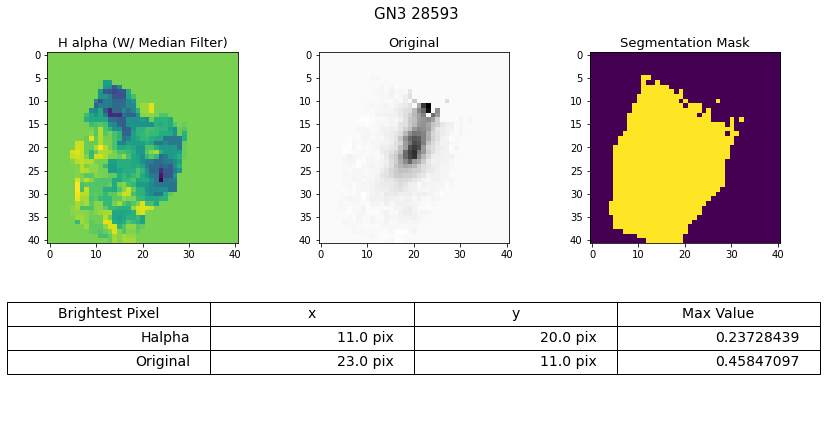

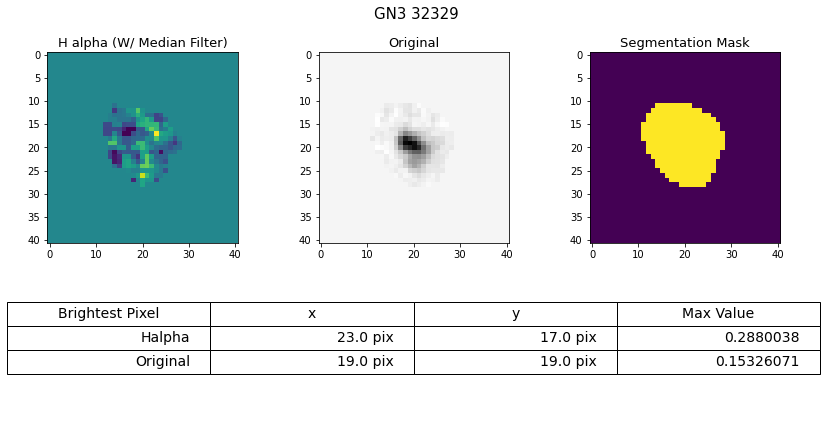

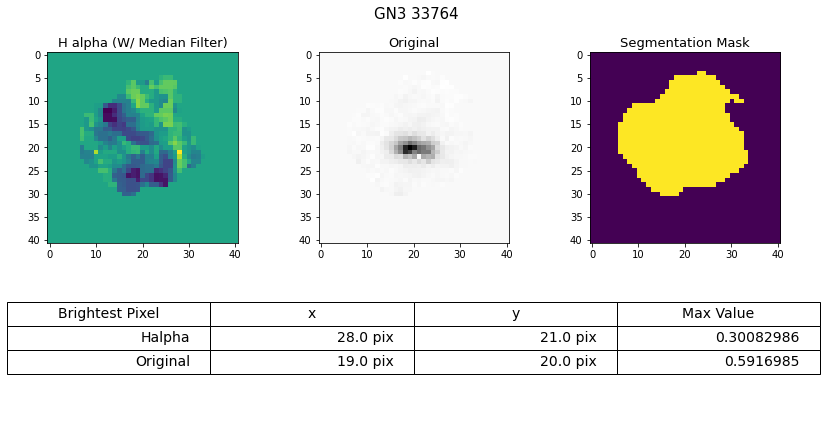

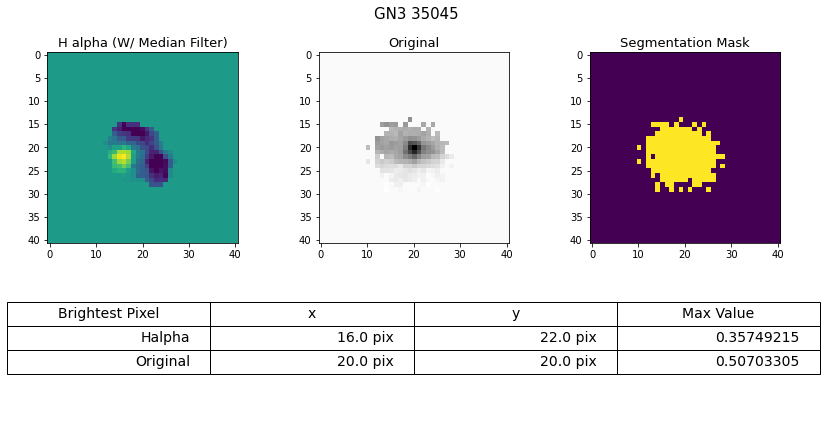

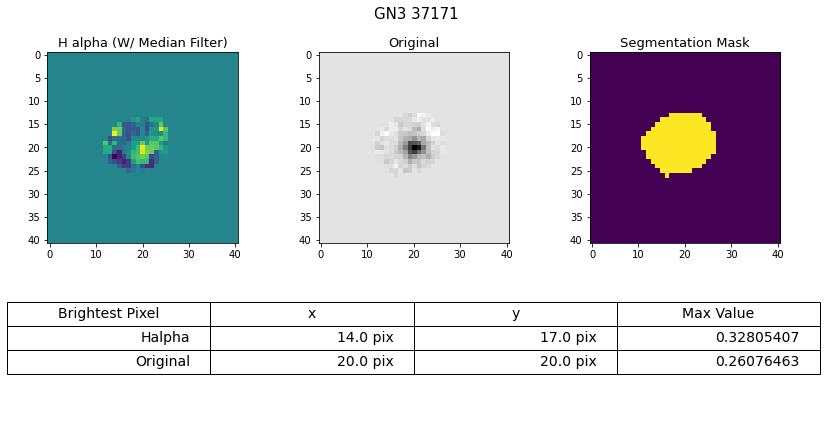

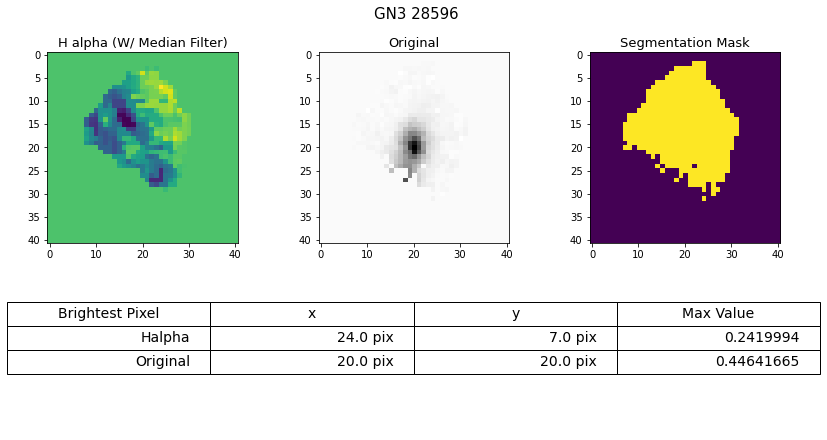

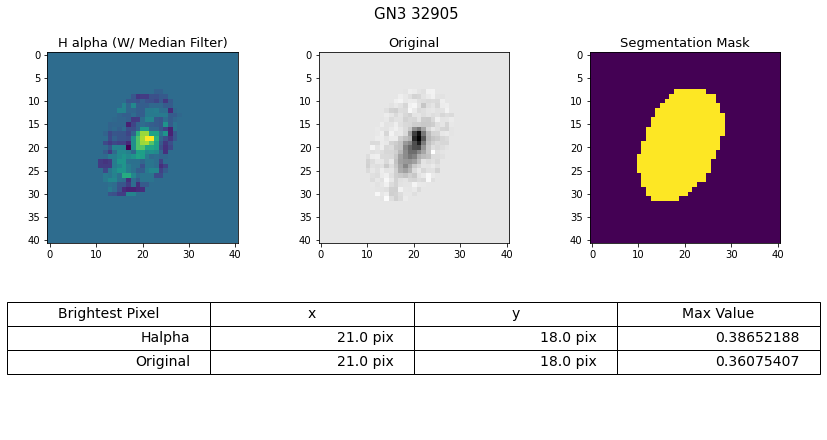

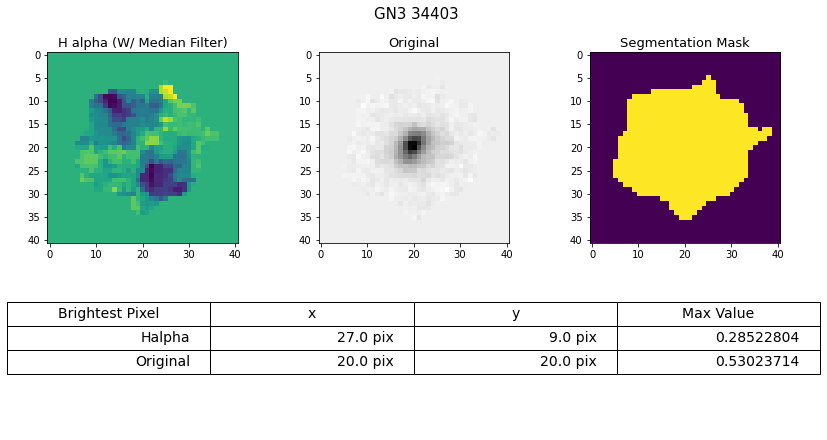

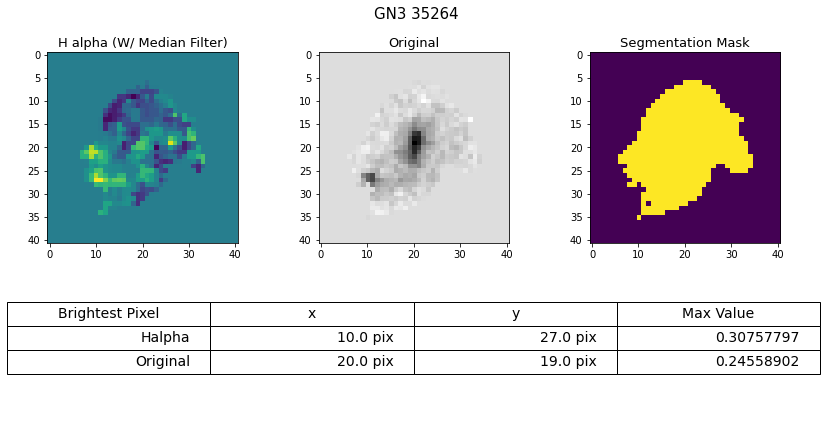

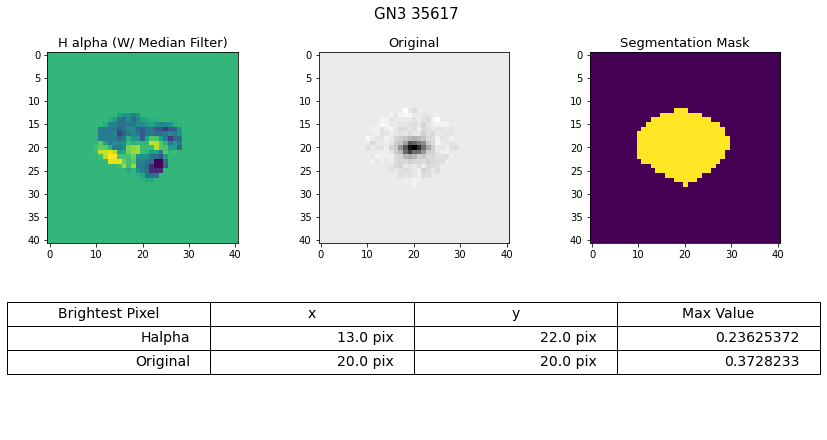

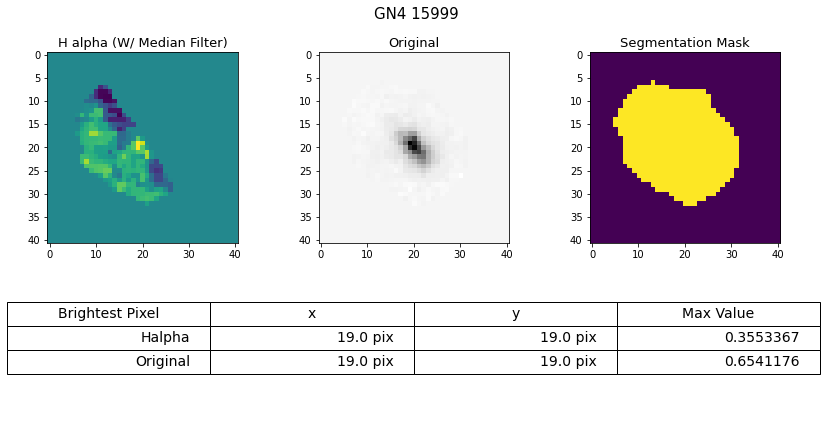

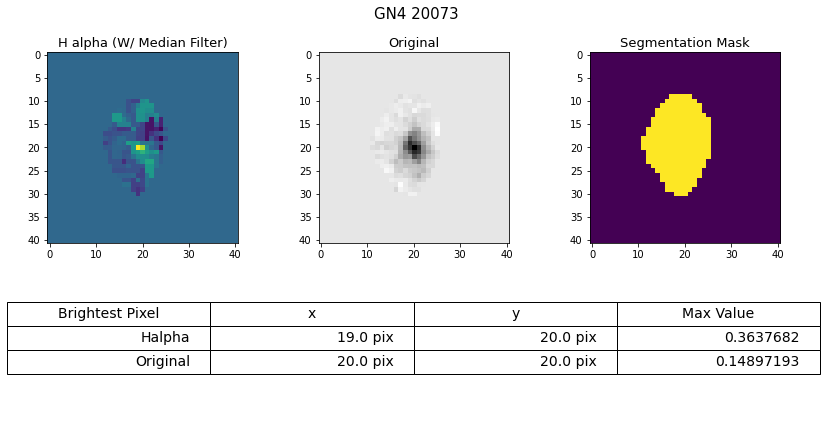

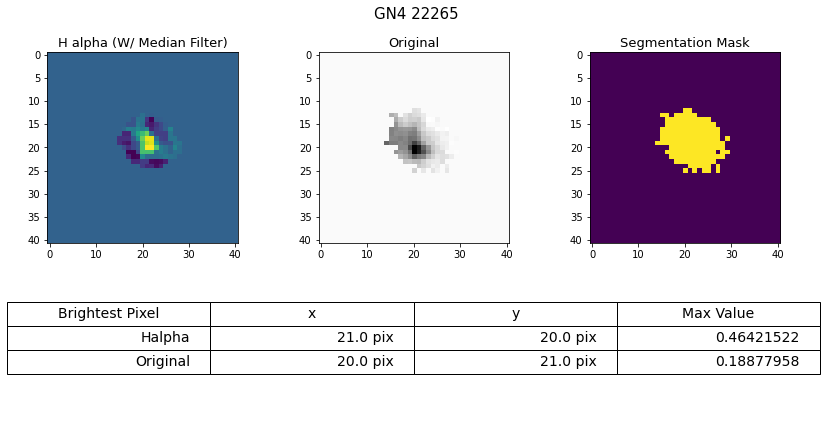

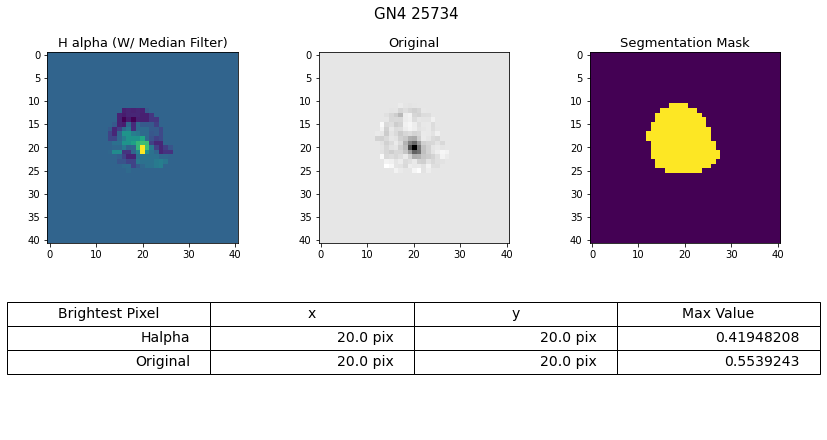

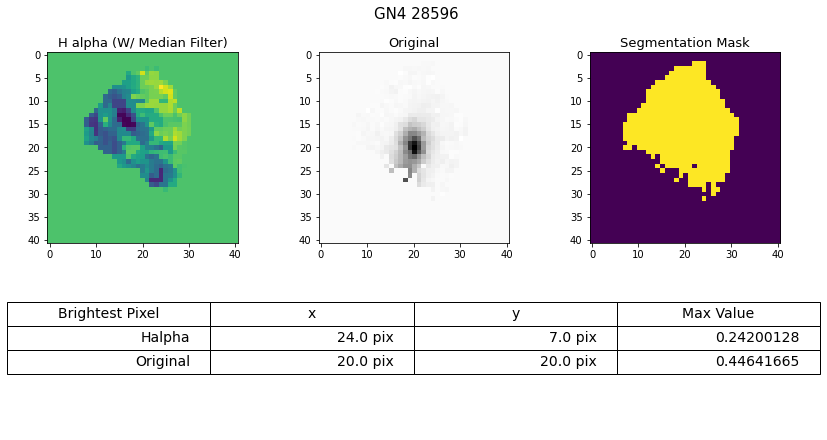

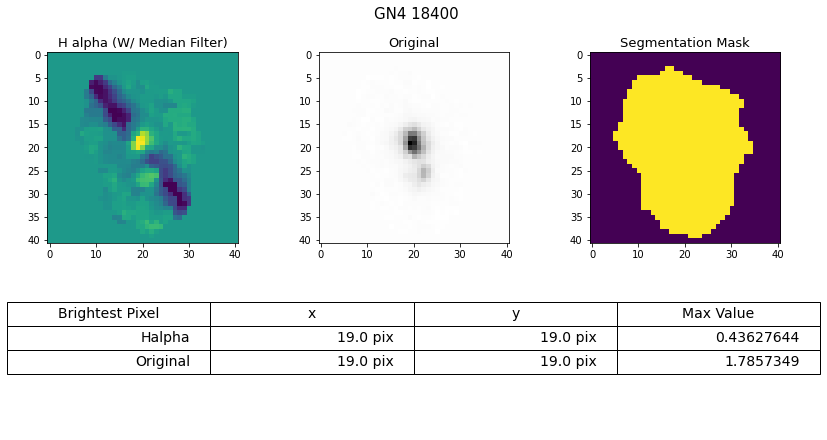

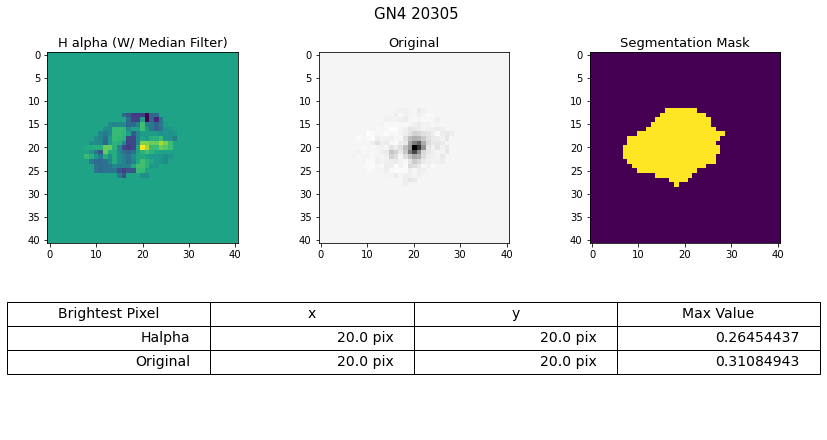

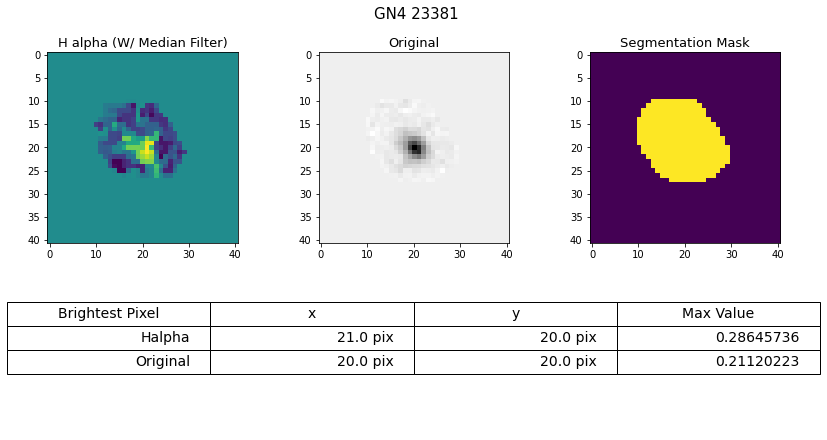

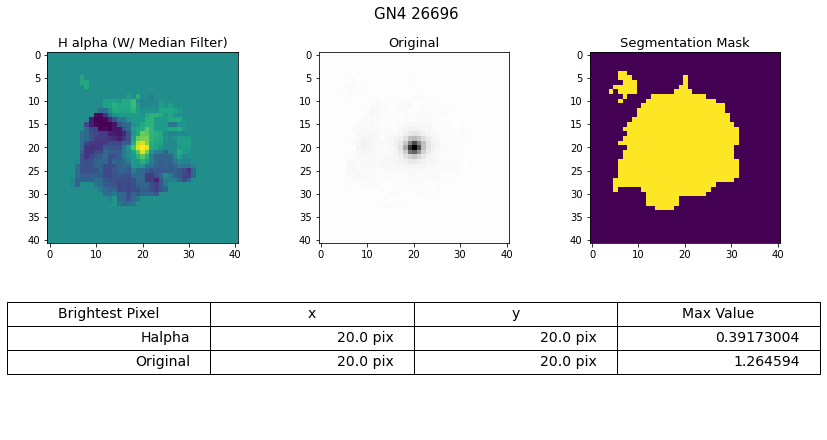

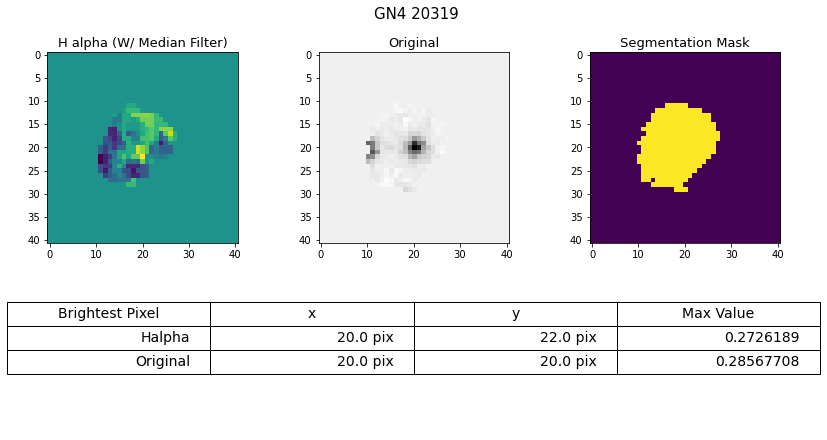

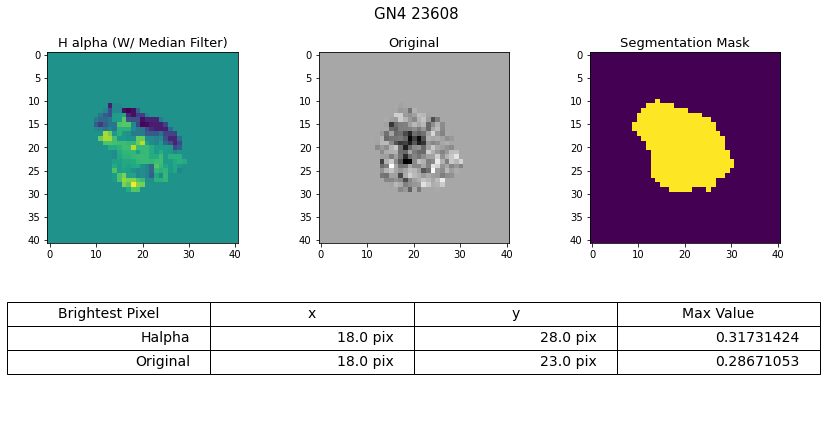

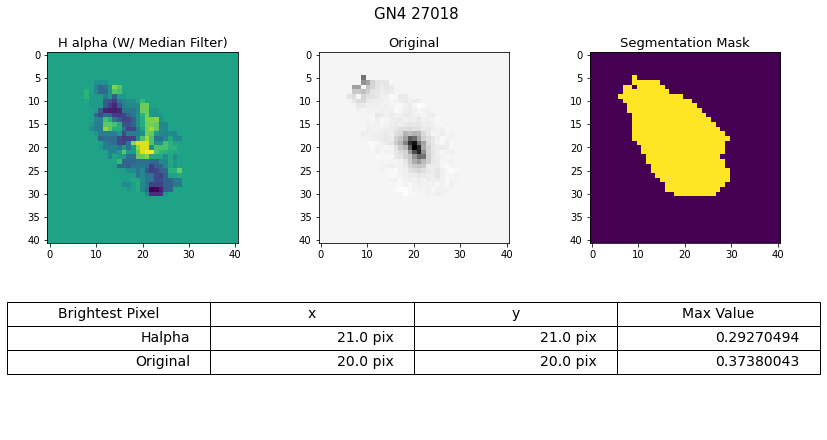

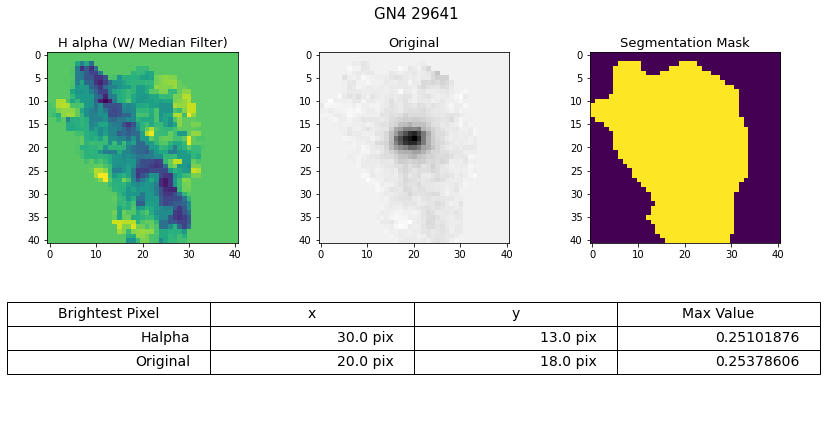

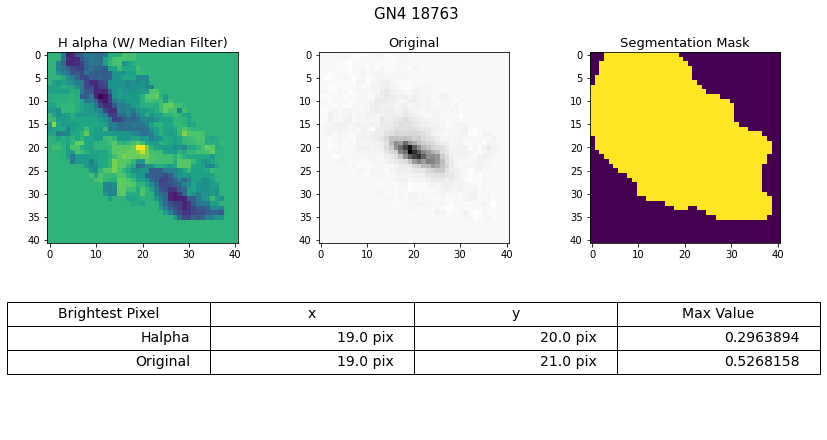

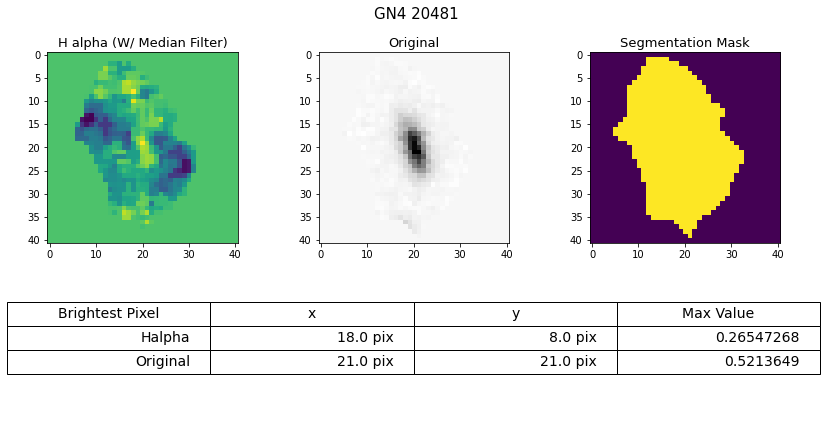

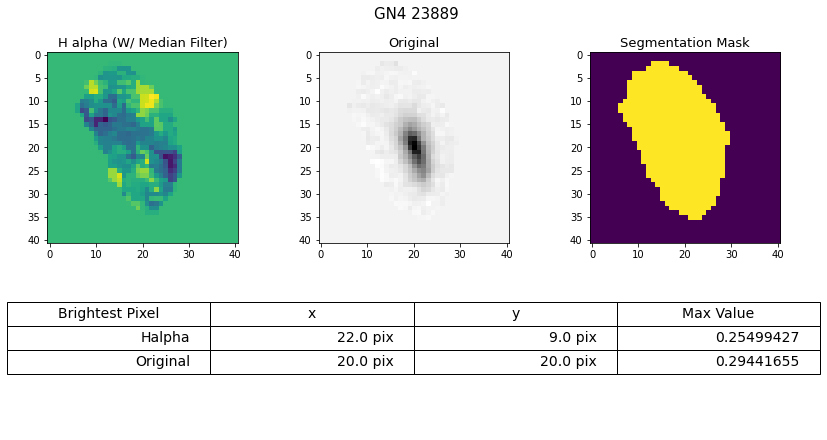

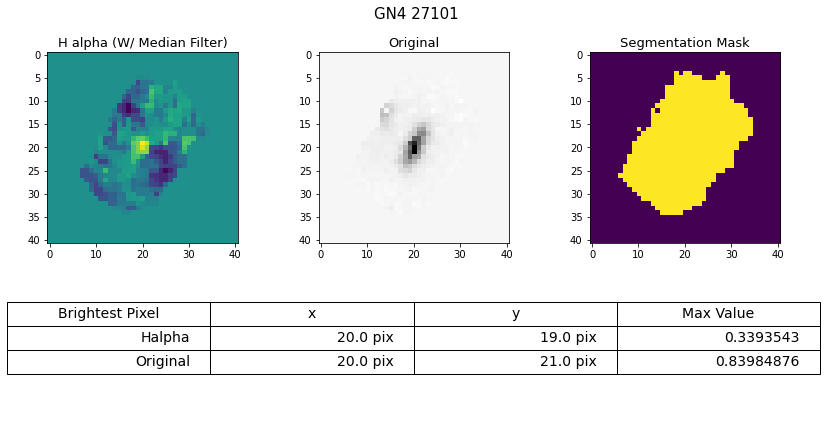

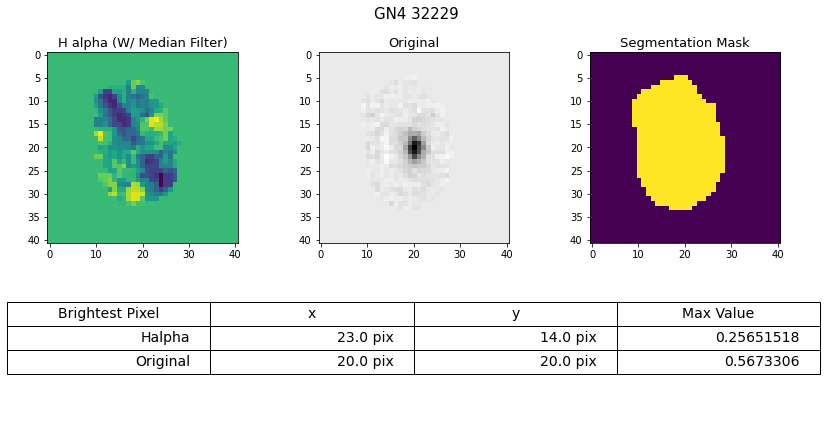

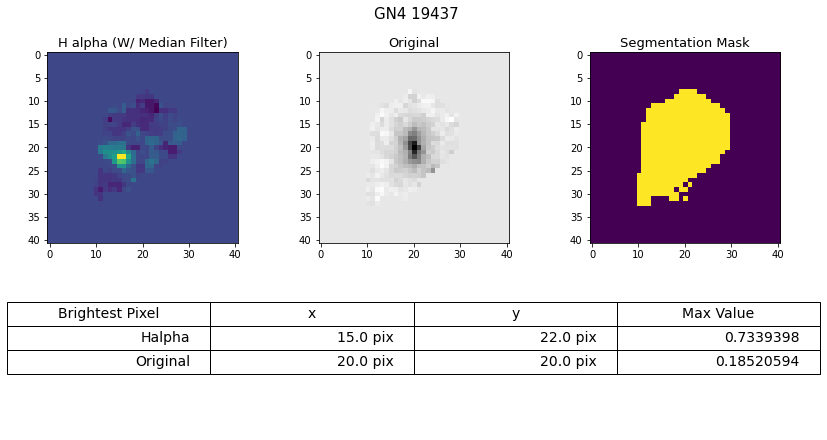

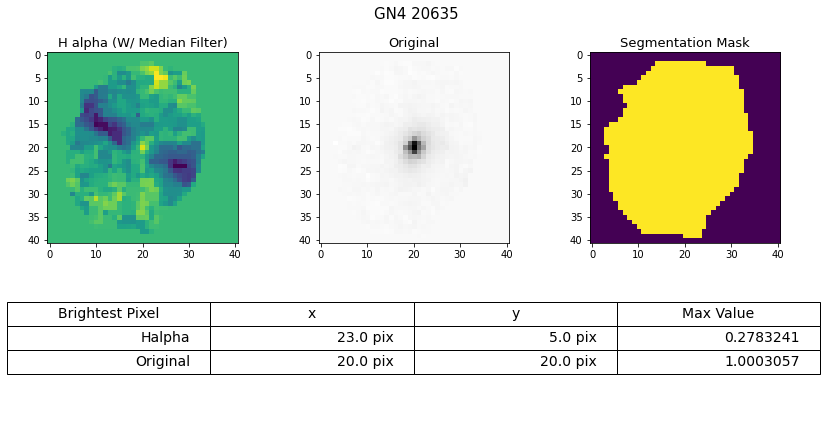

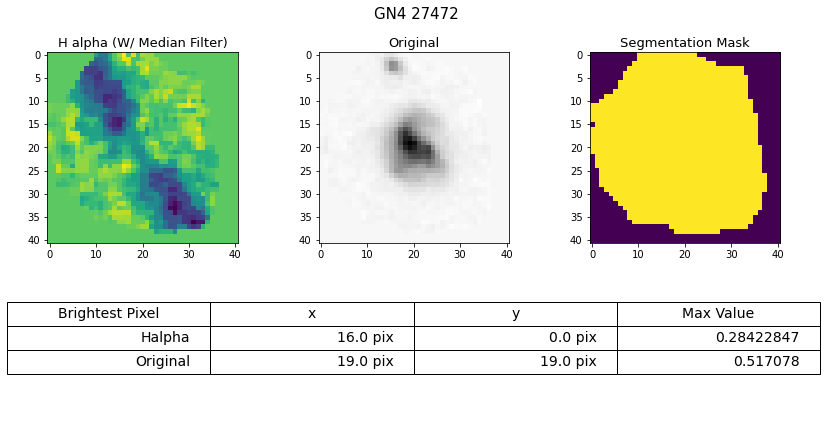

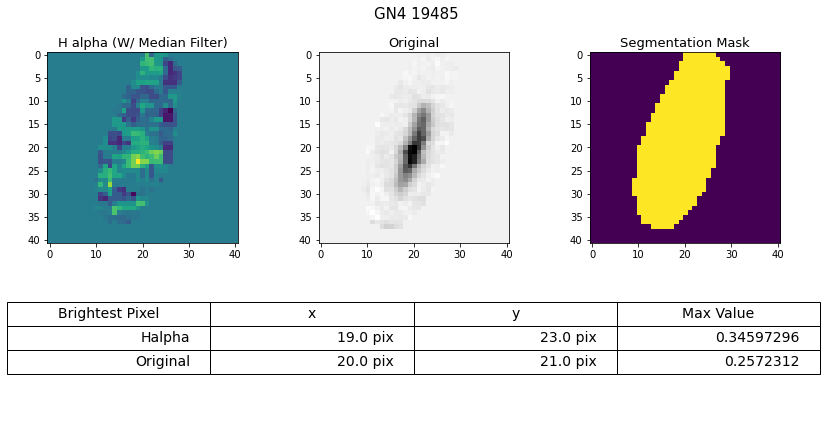

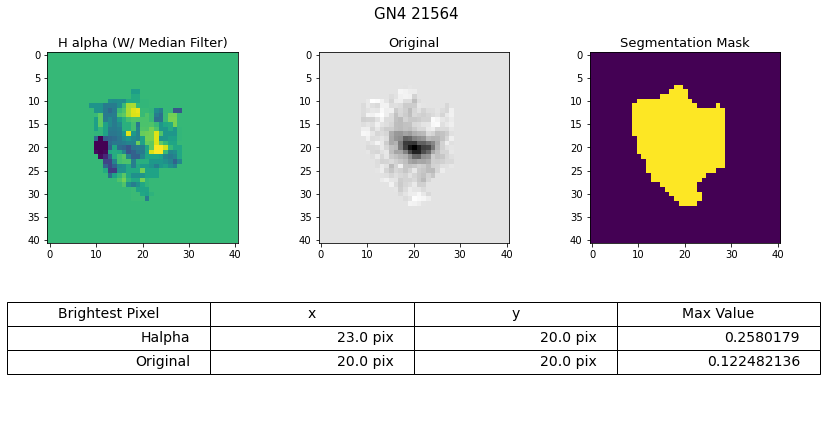

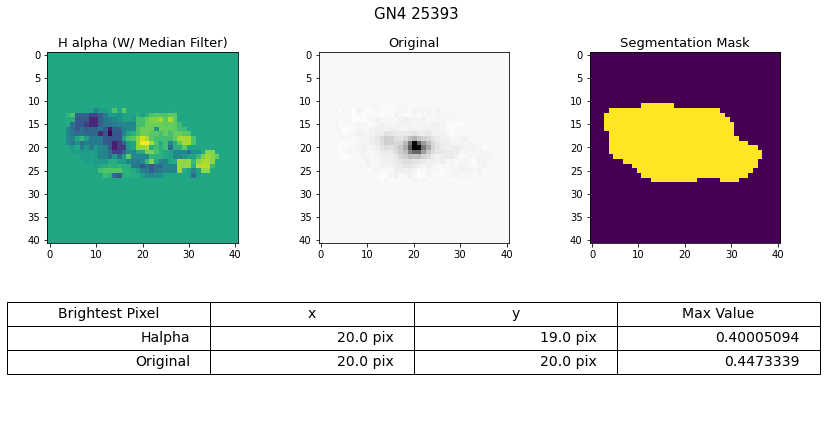

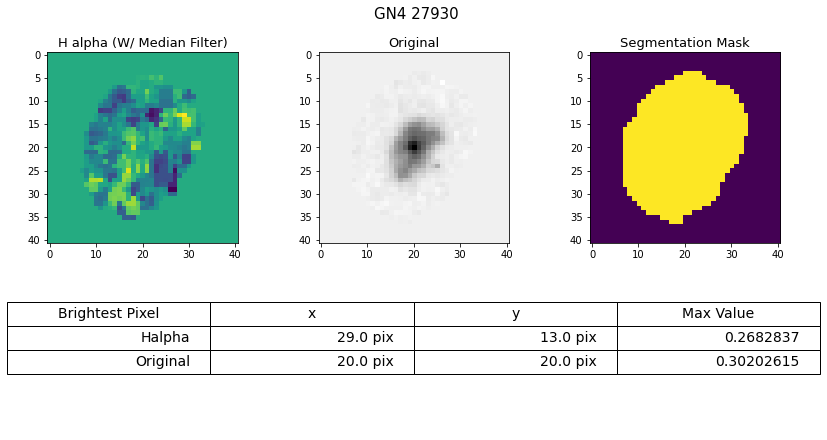

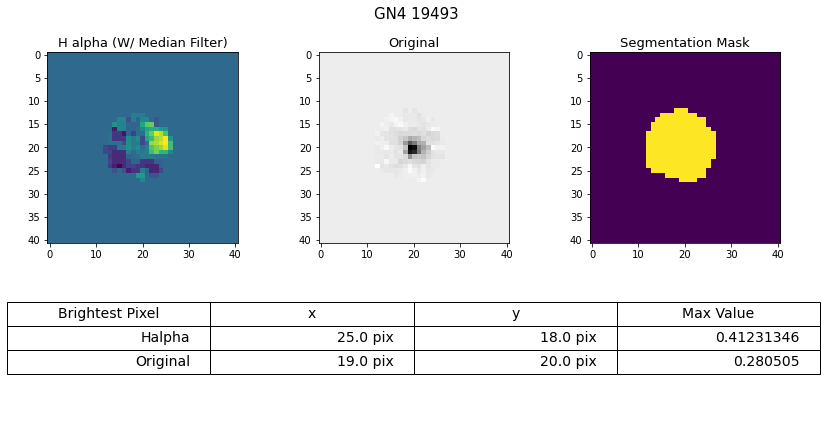

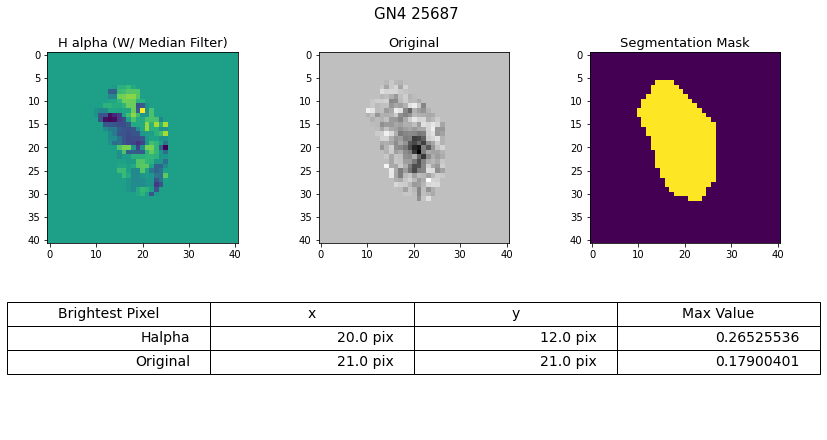

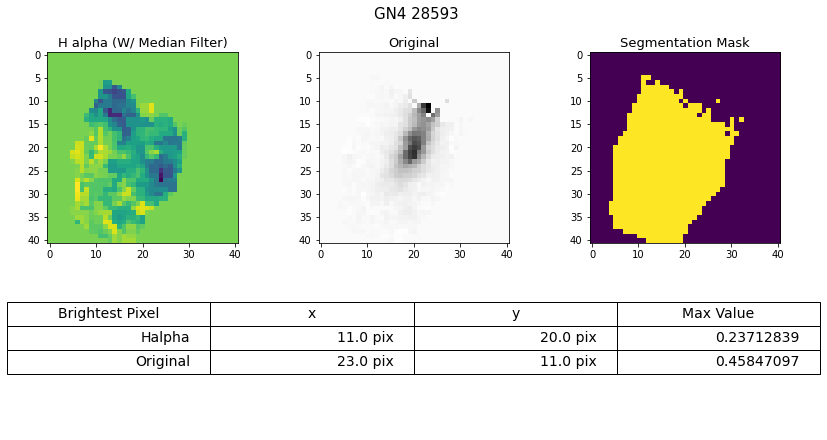

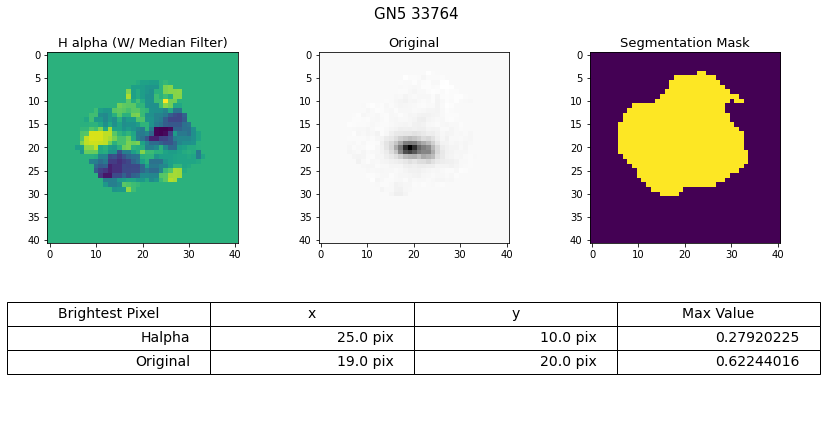

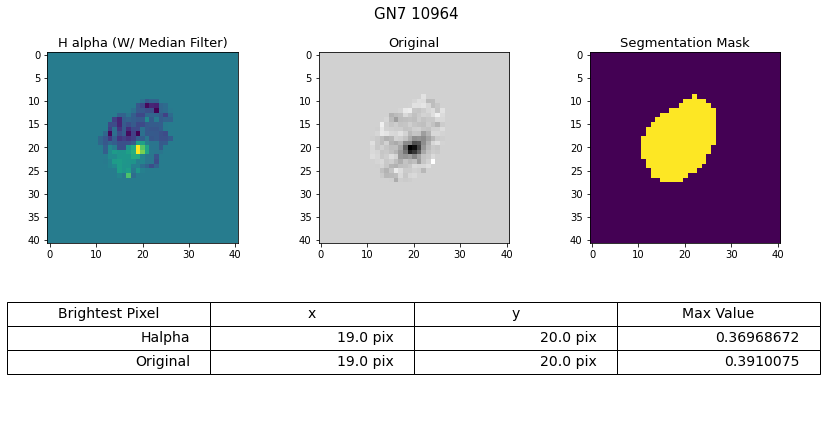

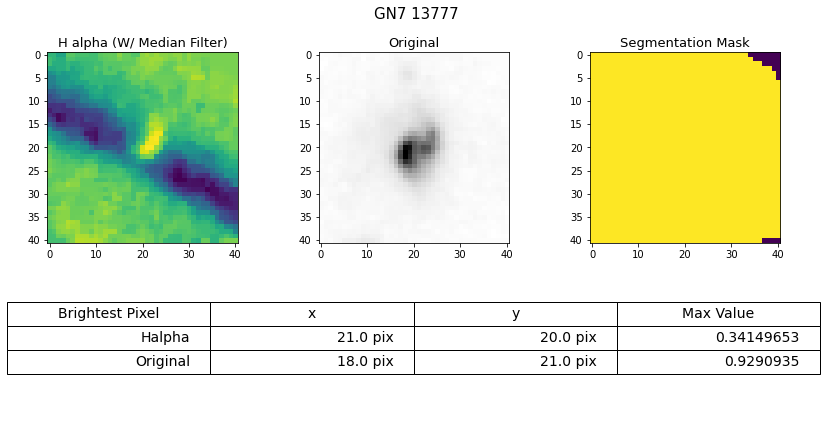

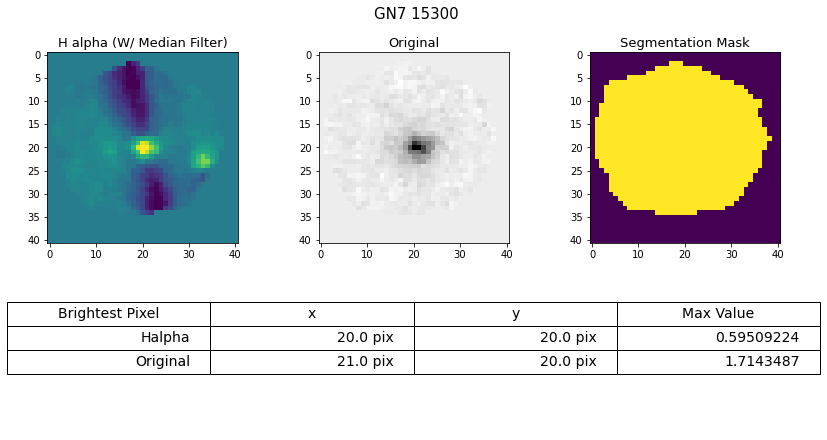

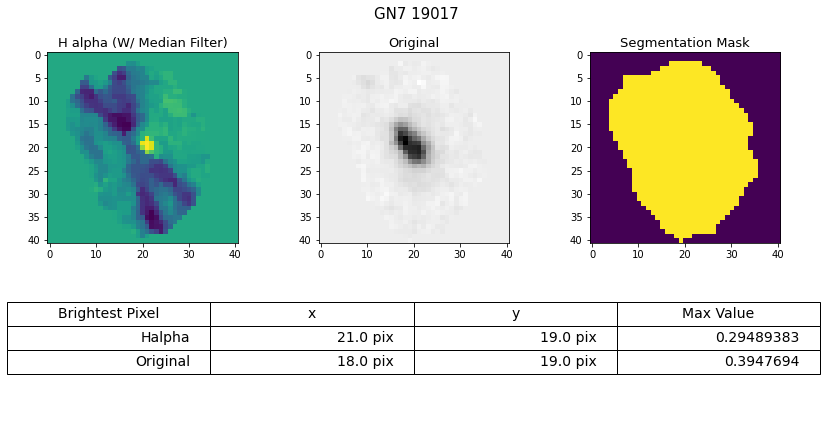

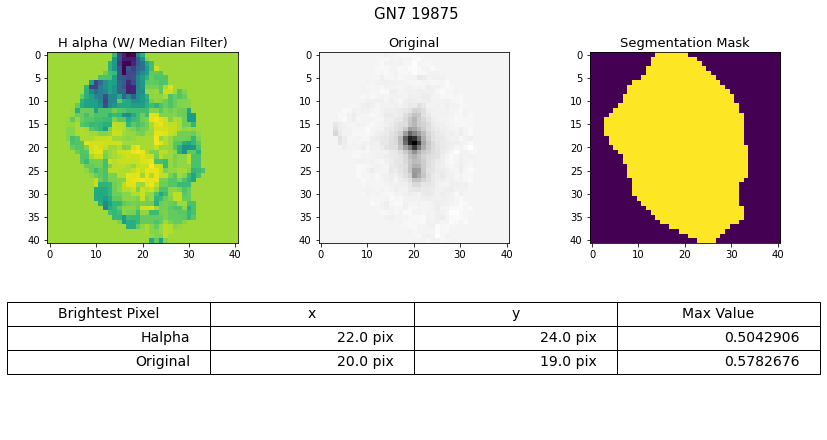

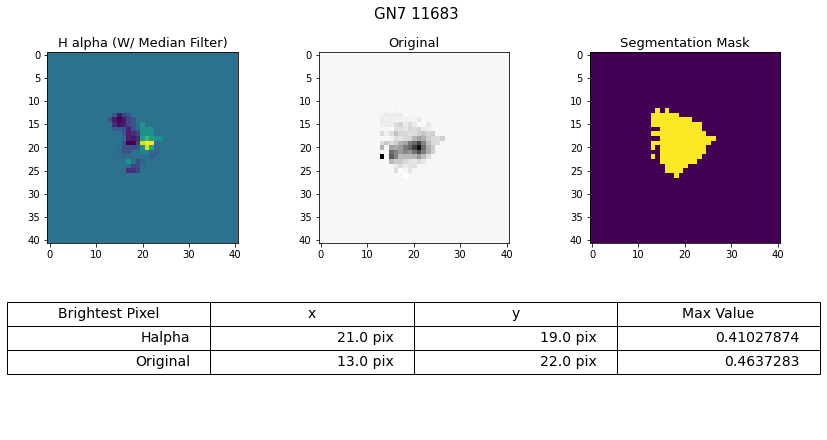

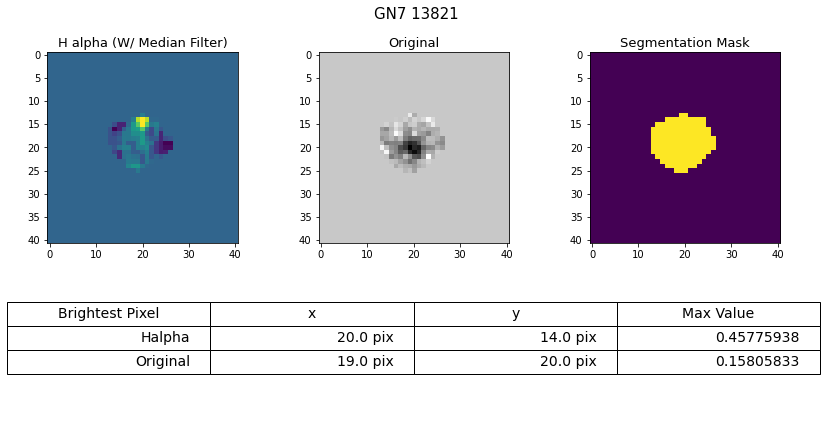

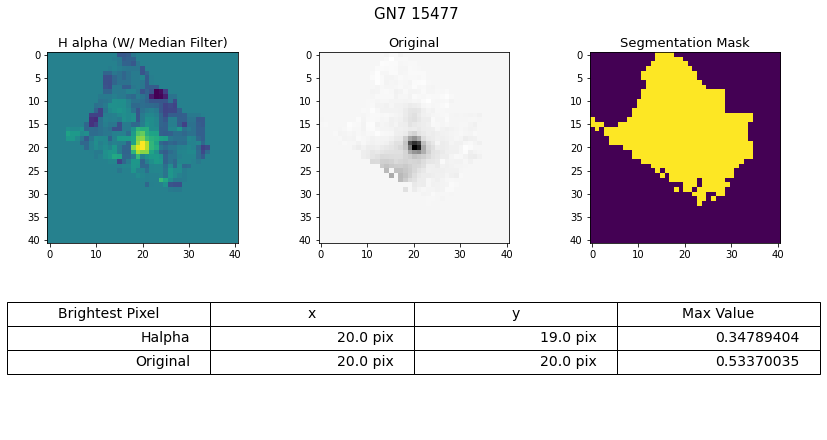

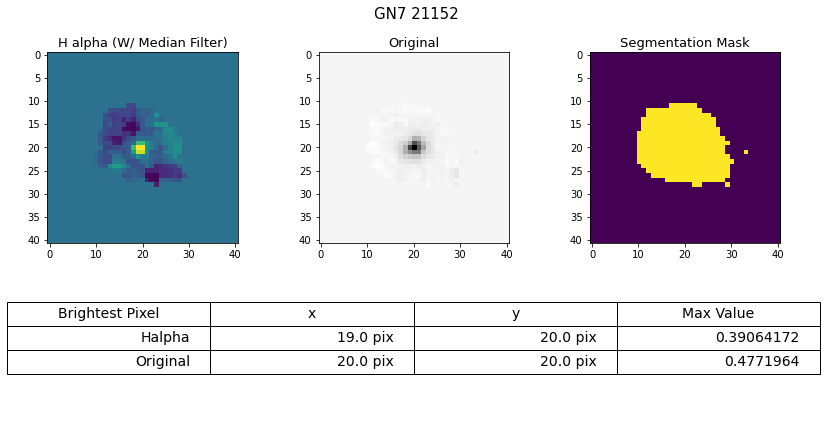

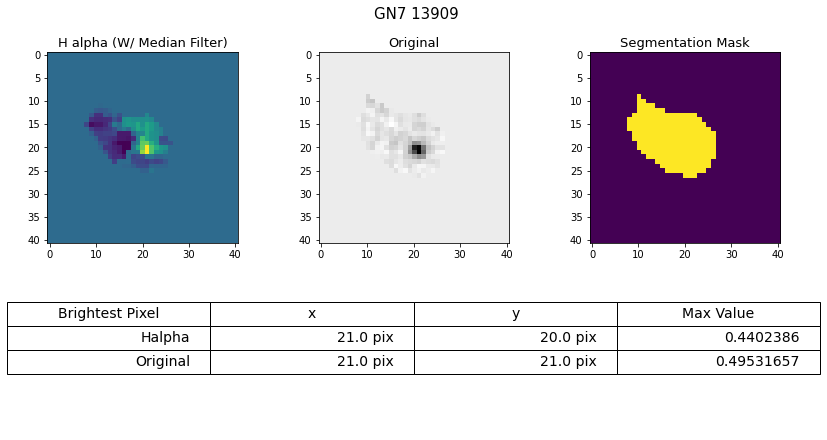

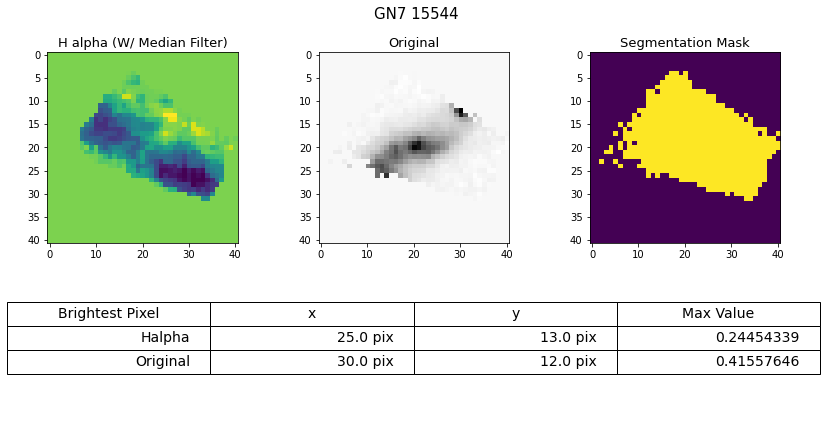

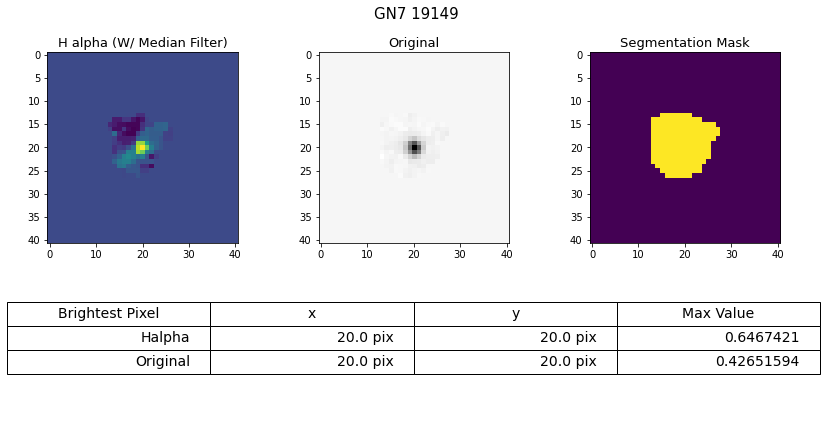

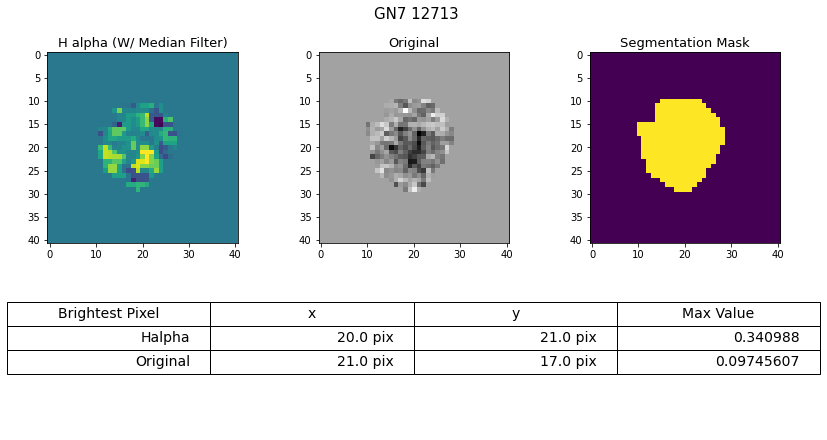

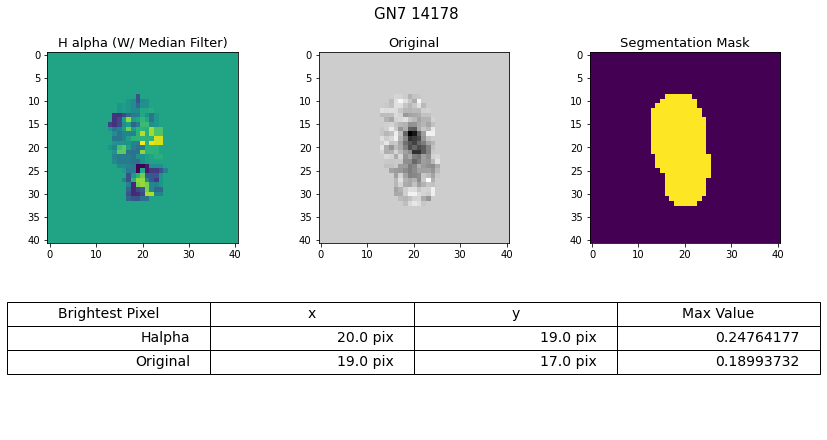

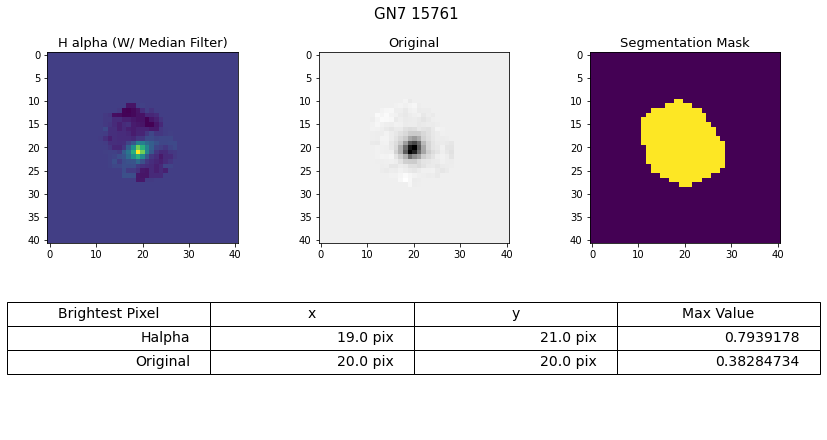

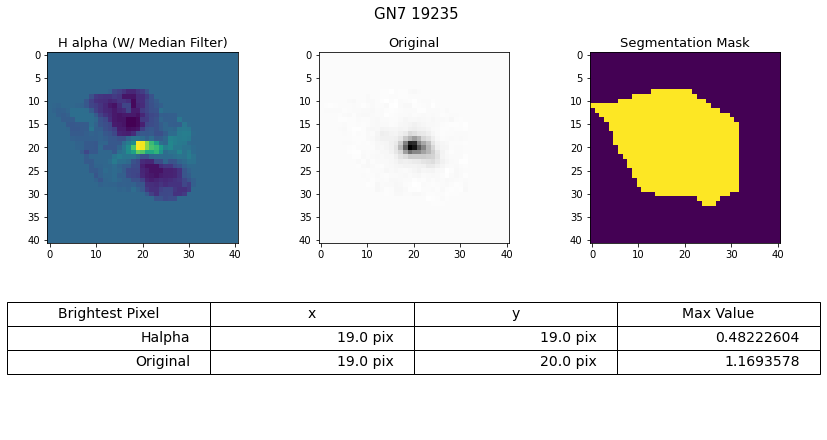

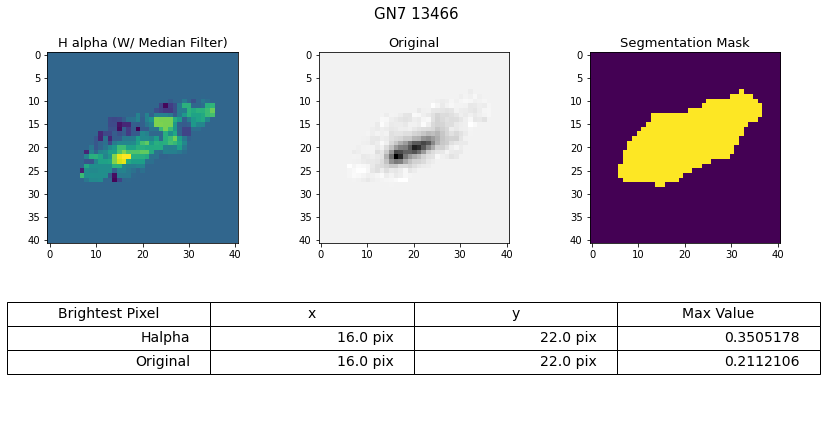

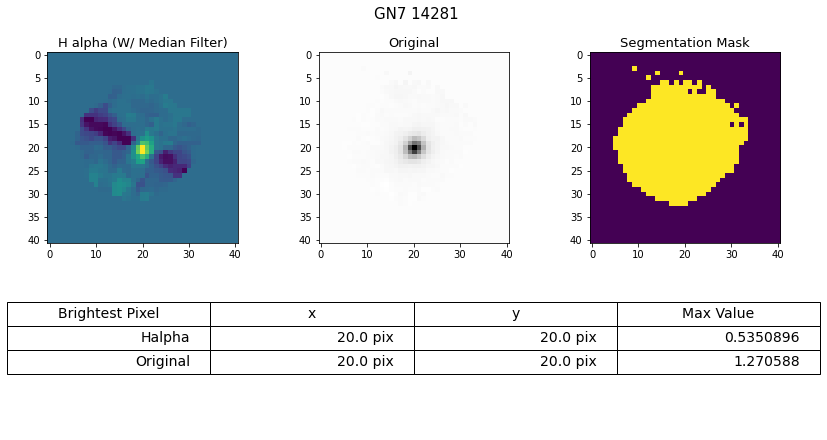

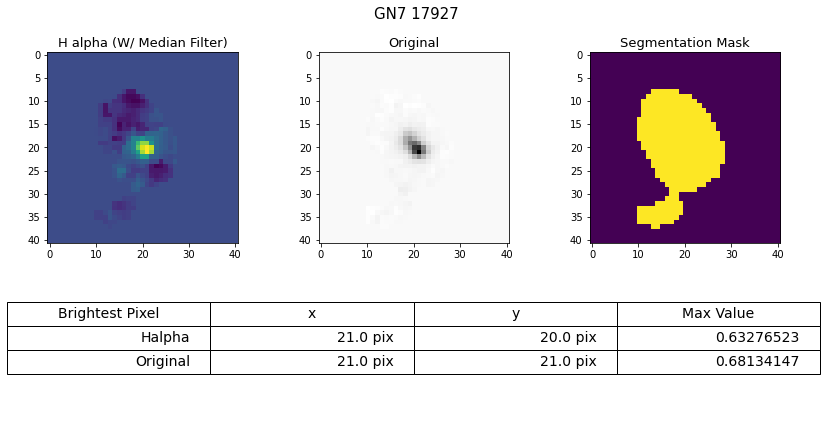

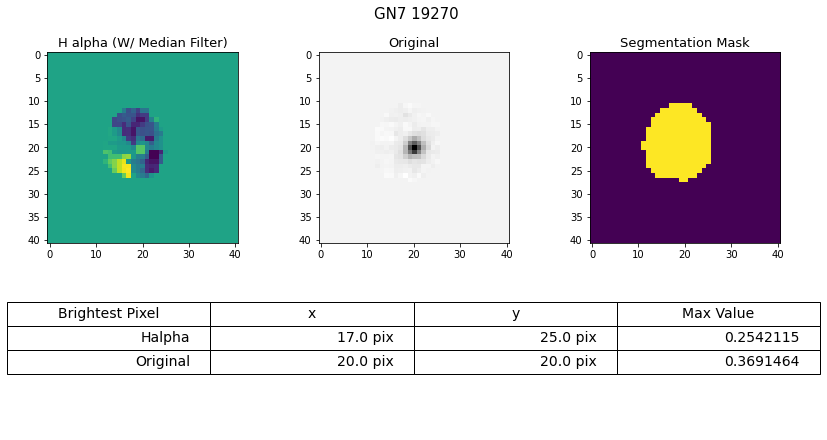

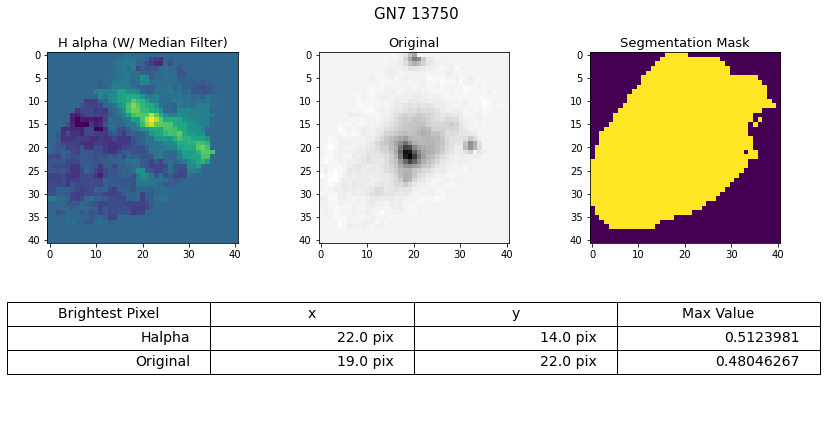

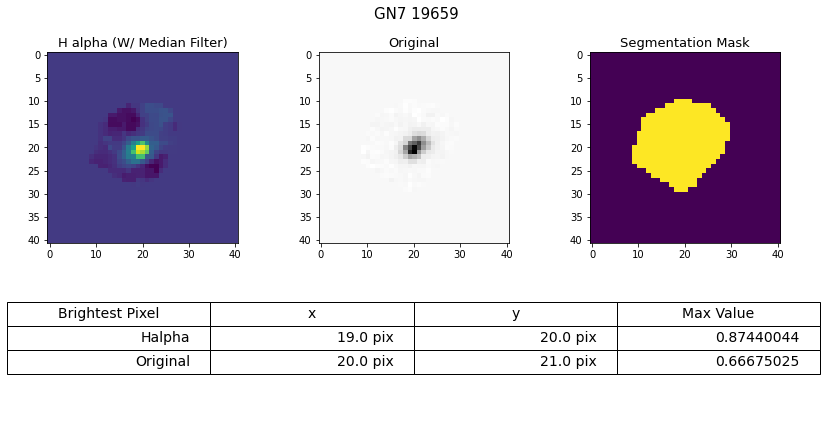

In [5]:
#Finalized Mergers
Sec = [GN1,GN2,GN3,GN4,GN5,GN7]
#Mergers W/ Issues
#Sec = [GN1_bad,GN2_bad,GN3_bad,GN4_bad,GN5_bad,GN7_bad]
Sec_name = ['GN1','GN2','GN3','GN4','GN5','GN7']

GN1_x_off,GN1_y_off,GN2_x_off,GN2_y_off,GN3_x_off,GN3_y_off = [],[],[],[],[],[]
GN4_x_off,GN4_y_off,GN5_x_off,GN5_y_off,GN7_x_off,GN7_y_off = [],[],[],[],[],[]

for i in range(len(Sec_name)):
#Listing all the Arrays for Each Section i.e. GN1
    RealData = []
    Mask = []
    im_med = []
    Halph = []
    Orig = []
    Title_fancy = []
    Title_save = []
    Ha_x = []
    Ha_y = []
    Orig_x = []
    Orig_y = []
    
    for j in range(len(Sec[i])):
        GID = Sec[i][j]
        field = Sec_name[i]
    
#Opening all the Fits Files
        H_a = fits.open(Ha_path+'{}/{}_{}.full.fits'.format(field,field,GID))
        Ha_fits = Ha_path+'{}/{}_{}.full.fits'.format(field,field,GID)
        Line = H_a['Line','Ha'].data     #Halpha data
        Continuum = H_a['Continuum','Ha'].data
        Contam = H_a['Contam','Ha'].data
        Raw = H_a['DSCI','F105W'].data
        
#Cropping and Correcting the data
        Halph.append(Line[59:100,59:100] - Continuum[59:100,59:100] - Contam[59:100,59:100])  #Fixing the Errors on Halpha
        Orig.append(Raw[59:100,59:100])
        Title_fancy.append(field + ' ' + str(GID))
        Title_save.append(field + '_'+str(GID))
        
#X and Y Posistions of Galaxy on Seg Map
        Y,X = np.where(seg_N == GID)
        Z = np.array([Y,X]).T     #Gives the X and Y positions of Object in Y,X
        #world = w.wcs_pix2world(Z,1)  #Gives RA and Dec Values of Object (May not be needed)
        
#Center Pixel of Ha on Seg Map
        RA = H_a[0].header['RA']                                
        DEC = H_a[0].header['DEC']    

        center = w.wcs_world2pix([[RA,DEC]],1)   #Finds the center pixels of the central RA and Dec of the Ha cutout
        hy = np.round(center[0][0])
        hx = np.round(center[0][1])
        center = np.array([int(hx),int(hy)])

#Making a Mask that is the Galaxy on Seg Map
        seg_mask = np.array(seg_N[center[0]-20:center[0]+21,center[1]-20:center[1]+21])
        seg_mask[seg_mask != GID] = 0
        seg_mask[seg_mask == GID] = 1
    
        Mask.append(np.array(seg_mask))
        
        Ha_img = Halph[j]
        Orig_img = Orig[j]
        
#Applying the Segmentation Map Mask
        Ha_img[Mask[j] == 0]=0
        Orig_img[Mask[j] == 0]=0
        
#Applying the Filter
        m=np.percentile(Ha_img,1.5)   #High Pass
        M=np.percentile(Ha_img,98.5)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        RealData.append(func.scaling_factor(Ha_img, m, M))  
        im_med.append(ndimage.median_filter(RealData[j], size = (3,3)))  #Median Smoothing
        
#Finding the Position of the Brightest Pixel and its value
        Ha_position = np.argwhere(im_med[j] == im_med[j].max()) * u.pixel
        Ha_max_value = np.amax(im_med[j])

        Orig_position = np.argwhere(Orig_img == Orig_img.max()) * u.pixel
        Orig_max_value = np.amax(Orig_img) 
        
#Appending the x and y for the Histogram
        Ha_x.append(Ha_position[0][1])
        Ha_y.append(Ha_position[0][0])
        Orig_x.append(Orig_position[0][1])
        Orig_y.append(Orig_position[0][0])
        
#Appending the x and y offset Separetly by Section
        if field == 'GN1':
            GN1_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN1_y_off.append(Ha_y[j].value - Orig_y[j].value)
        if field == 'GN2':
            GN2_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN2_y_off.append(Ha_y[j].value - Orig_y[j].value)
        if field == 'GN3':
            GN3_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN3_y_off.append(Ha_y[j].value - Orig_y[j].value)
        if field == 'GN4':
            GN4_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN4_y_off.append(Ha_y[j].value - Orig_y[j].value)
        if field == 'GN5':
            GN5_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN5_y_off.append(Ha_y[j].value - Orig_y[j].value)
        if field == 'GN7':
            GN7_x_off.append(Ha_x[j].value - Orig_x[j].value)
            GN7_y_off.append(Ha_y[j].value - Orig_y[j].value)
            
#Making a table with Information of the Pixels location and values
        Test = {'Ha_x':pd.Series(Ha_position[0][1]), 'Ha_y':pd.Series(Ha_position[0][0]),
                'Ha_max_value':pd.Series(Ha_max_value),'Orig_x':pd.Series(Orig_position[0][1]),
                'Orig_y':pd.Series(Orig_position[0][0]),'Orig_max_value':pd.Series(Orig_max_value)}
        Position_table = pd.DataFrame(Test)    
        table_data=[['Halpha',Ha_position[0][1],Ha_position[0][0],Ha_max_value],
                    ['Original',Orig_position[0][1],Orig_position[0][0],Orig_max_value]]
        
#Plotting the Figures
        func.plot_fig(3,im_med[j],Orig[j],Mask[j],0,table_data,Title_fancy[j])
# Finalized Mergers Save Line
#            plt.savefig(image_path+'{}/{}_{}.png'.format(field,field,Title_save[j]),bbox_inches = 'tight')

Now we will be applying the randomized H-alpha images. We will loop over this 6 separate times to get a large sample size. Furthermore we will save our results so we do not have to run this again (as it takes a long time).

In [6]:
#This chunk of code is plotting the Ha images using random numbers to try and 
#remove a second, unwanted gaucian in the data

Sec_name = ['GN1','GN2','GN3','GN4','GN5','GN7']
Sec = [GN1,GN2,GN3,GN4,GN5,GN7]

Random_loops = [1,2,3,4,5,6]

for p in range(len(Random_loops)):
                   
#Creating Temporary files to save the offsets    
    Saved_x_offset,Saved_y_offset = [],[]
    
    GN1_x_off_rand,GN1_y_off_rand,GN2_x_off_rand,GN2_y_off_rand,GN3_x_off_rand,GN3_y_off_rand = [],[],[],[],[],[]
    GN4_x_off_rand,GN4_y_off_rand,GN5_x_off_rand,GN5_y_off_rand,GN7_x_off_rand,GN7_y_off_rand = [],[],[],[],[],[]
    
    for i in range(len(Sec_name)):       #Looping over the Galaxy Sections
    #Listing all the Arrays for Each Section i.e. GN1
        RealData = []
        Mask = []
        im_med = []
        Halph = []
        Orig = []
        Title_fancy = []
        Title_save = []
        Ha_x = []
        Ha_y = []
        Orig_x = []
        Orig_y = []
    
        for j in range(len(Sec[i])):   #Looping over the Galaxies in each Section
            GID = Sec[i][j]
            field = Sec_name[i]
            rand = np.random.rand(41,41)

#Opening all the Fits Files
            H_a = fits.open(Ha_path+'{}/{}_{}.full.fits'.format(field,field,GID))
            Ha_fits = Ha_path+'{}/{}_{}.full.fits'.format(field,field,GID)
            Line = H_a['Line','Ha'].data     #Halpha data
            Continuum = H_a['Continuum','Ha'].data
            Contam = H_a['Contam','Ha'].data
            Raw = H_a['DSCI','F105W'].data
    
            #Halph.append(Line[59:100,59:100] - Continuum[59:100,59:100] - Contam[59:100,59:100])  #Fixing the Errors on Halpha
            Orig.append(Raw[59:100,59:100])
            Title_fancy.append(field + ' ' + str(GID))
            Title_save.append(field + '_'+str(GID))
        
#X and Y Posistions of Galaxy on Seg Map
            Y,X = np.where(seg_N == GID)
            Z = np.array([Y,X]).T     #Gives the X and Y positions of Object in Y,X
            #world = w.wcs_pix2world(Z,1)  #Gives RA and Dec Values of Object (May not be needed)
        
#Center Pixel of Ha on Seg Map
            RA = H_a[0].header['RA']                                
            DEC = H_a[0].header['DEC']    

            center = w.wcs_world2pix([[RA,DEC]],1)   #Finds the center pixels of the central RA and Dec of the Ha cutout
            hy = np.round(center[0][0])
            hx = np.round(center[0][1])
            center = np.array([int(hx),int(hy)])

#Making a Mask that is the Galaxy on Seg Map
            seg_mask = np.array(seg_N[center[0]-20:center[0]+21,center[1]-20:center[1]+21])
            seg_mask[seg_mask != GID] = 0
            seg_mask[seg_mask == GID] = 1
    
            Mask.append(np.array(seg_mask))
        
#Applying the Segmentation Map Mask
            rand[Mask[j] == 0]=0
            Orig[j][Mask[j] == 0]=0
    
#Applying the Filter
            m=np.percentile(rand,1.5)   #High Pass
            M=np.percentile(rand,98.5)  #Low Pass
            if M < np.abs(m)*6:
                M = np.abs(m)*6
            RealData.append(func.scaling_factor(rand, m, M))  
            im_med.append(ndimage.median_filter(RealData[j], size = (3,3)))  #Median Smoothing
        
#Finding the Position of the Brightest Pixel and its value
            Ha_position = np.argwhere(im_med[j] == im_med[j].max()) * u.pixel
            Ha_max_value = np.amax(im_med[j])

            Orig_position = np.argwhere(Orig[j] == Orig[j].max()) * u.pixel
            Orig_max_value = np.amax(Orig[j]) 
        
#Appending the x and y for the Histogram
            Ha_x.append(Ha_position[0][1])
            Ha_y.append(Ha_position[0][0])
            Orig_x.append(Orig_position[0][1])
            Orig_y.append(Orig_position[0][0])
        
#Appending the x and y offset Separetly by Section
            if field == 'GN1':
                GN1_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN1_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN1_x_off_rand[j])
                Saved_y_offset.append(GN1_y_off_rand[j])
            if field == 'GN2':
                GN2_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN2_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN2_x_off_rand[j])
                Saved_y_offset.append(GN2_y_off_rand[j])
            if field == 'GN3':
                GN3_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN3_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN3_x_off_rand[j])
                Saved_y_offset.append(GN3_y_off_rand[j])
            if field == 'GN4':
                GN4_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN4_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN4_x_off_rand[j])
                Saved_y_offset.append(GN4_y_off_rand[j])
            if field == 'GN5':
                GN5_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN5_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN5_x_off_rand[j])
                Saved_y_offset.append(GN5_y_off_rand[j])
            if field == 'GN7':
                GN7_x_off_rand.append(Ha_x[j].value - Orig_x[j].value)
                GN7_y_off_rand.append(Ha_y[j].value - Orig_y[j].value)
                Saved_x_offset.append(GN7_x_off_rand[j])
                Saved_y_offset.append(GN7_y_off_rand[j])
            
#Making a table with Information of the Pixels location and values
            Test = {'Ha_x':pd.Series(Ha_position[0][1]), 'Ha_y':pd.Series(Ha_position[0][0]),
                    'Ha_max_value':pd.Series(Ha_max_value),'Orig_x':pd.Series(Orig_position[0][1]),
                    'Orig_y':pd.Series(Orig_position[0][0]),'Orig_max_value':pd.Series(Orig_max_value)}
            Position_table = pd.DataFrame(Test)    
            table_data=[['Halpha',Ha_position[0][1],Ha_position[0][0],Ha_max_value],
                        ['Original',Orig_position[0][1],Orig_position[0][0],Orig_max_value]]
#Plotting the Figures
            #plot_fig(3,im_med[j],Orig[j],Mask[j],0,table_data,Title_fancy[j])
    
#Saving the Offsets
#    if p == 0:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_1_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_1_test.csv')
#    if p == 1:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_2_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_2_test.csv')
#    if p == 2:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_3_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_3_test.csv')
#    if p == 3:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_4_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_4_test.csv')
#    if p == 4:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_5_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_5_test.csv')
#    if p == 5:
#        pd.DataFrame(Saved_x_offset).to_csv(Ha_path+'Saved_x_offset_6_test.csv')
#        pd.DataFrame(Saved_y_offset).to_csv(Ha_path+'Saved_y_offset_6_test.csv')

Reloading the randomized H-alpha data and placing it into its own array

In [8]:
x_off_rand = []
y_off_rand = []

X_off_1 = pd.read_csv(corrected_path+'Saved_x_offset_1.csv')
X_off_1.columns = ['id','offset']
Y_off_1 = pd.read_csv(corrected_path+'Saved_y_offset_1.csv')
Y_off_1.columns = ['id','offset']

X_off_2 = pd.read_csv(corrected_path+'Saved_x_offset_2.csv')
X_off_2.columns = ['id','offset']
Y_off_2 = pd.read_csv(corrected_path+'Saved_y_offset_2.csv')
Y_off_2.columns = ['id','offset']

X_off_3 = pd.read_csv(corrected_path+'Saved_x_offset_3.csv')
X_off_3.columns = ['id','offset']
Y_off_3 = pd.read_csv(corrected_path+'Saved_y_offset_3.csv')
Y_off_3.columns = ['id','offset']

X_off_4 = pd.read_csv(corrected_path+'Saved_x_offset_4.csv')
X_off_4.columns = ['id','offset']
Y_off_4 = pd.read_csv(corrected_path+'Saved_y_offset_4.csv')
Y_off_4.columns = ['id','offset']

X_off_5 = pd.read_csv(corrected_path+'Saved_x_offset_5.csv')
X_off_5.columns = ['id','offset']
Y_off_5 = pd.read_csv(corrected_path+'Saved_y_offset_5.csv')
Y_off_5.columns = ['id','offset']

X_off_6 = pd.read_csv(corrected_path+'Saved_x_offset_6.csv')
X_off_6.columns = ['id','offset']
Y_off_6 = pd.read_csv(corrected_path+'Saved_y_offset_6.csv')
Y_off_6.columns = ['id','offset']

for i in range(len(X_off_1)):
    x_off_rand.append(X_off_1['offset'][i])
    x_off_rand.append(X_off_2['offset'][i])
    x_off_rand.append(X_off_3['offset'][i])
    x_off_rand.append(X_off_4['offset'][i])
    x_off_rand.append(X_off_5['offset'][i])
    x_off_rand.append(X_off_6['offset'][i])
    
    y_off_rand.append(Y_off_1['offset'][i])
    y_off_rand.append(Y_off_2['offset'][i])
    y_off_rand.append(Y_off_3['offset'][i])
    y_off_rand.append(Y_off_4['offset'][i])
    y_off_rand.append(Y_off_5['offset'][i])
    y_off_rand.append(Y_off_6['offset'][i])

Plotting the data of the real offset vs. the randomized offset

/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

Text(0.5, 1.0, 'GN Y Random Total Offset')

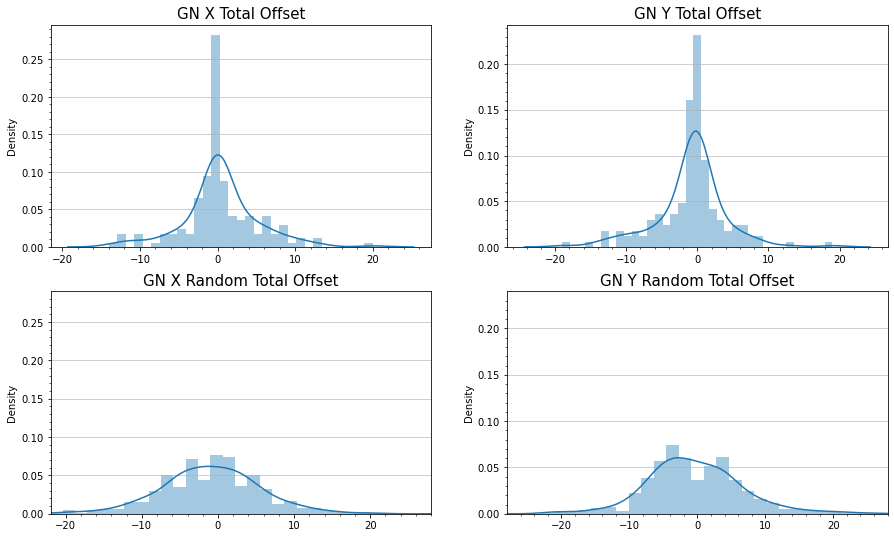

In [9]:
import seaborn as sea
x_offset = []
y_offset = []

#Real data for Ha
for i in range(len(GN1_x_off)):
    x_offset.append(GN1_x_off[i])
    y_offset.append(GN1_y_off[i])

for i in range(len(GN2_x_off)):
    x_offset.append(GN2_x_off[i])
    y_offset.append(GN2_y_off[i])

for i in range(len(GN3_x_off)):
    x_offset.append(GN3_x_off[i])
    y_offset.append(GN3_y_off[i])

for i in range(len(GN4_x_off)):
    x_offset.append(GN4_x_off[i])
    y_offset.append(GN4_y_off[i])

for i in range(len(GN5_x_off)):
    x_offset.append(GN5_x_off[i])
    y_offset.append(GN5_y_off[i])

for i in range(len(GN7_x_off)):
    x_offset.append(GN7_x_off[i])
    y_offset.append(GN7_y_off[i])

    
#Plotting the Histograms in Seaborn
plt.figure(figsize=[15,9])
    
plt.subplot(221)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(x_offset)
plt.minorticks_on()
plt.title("GN X Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/x_offset.png',bbox_inches = 'tight')

plt.subplot(222)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(y_offset)
plt.minorticks_on()
plt.title("GN Y Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/y_offset.png',bbox_inches = 'tight')
    
plt.subplot(223)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(x_off_rand)
plt.xlim(-22, 28)
plt.ylim(0, .29)
plt.minorticks_on()
plt.title("GN X Random Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/Bad_Ha/x_offset_rand.png',bbox_inches = 'tight')

plt.subplot(224)
plt.grid(axis = 'y',alpha = .75)
sea.distplot(y_off_rand)
plt.xlim(-28, 28)
plt.ylim(0, .24)
plt.minorticks_on()
plt.title("GN Y Random Total Offset", fontsize = 15)
#plt.savefig('/Users/felixmartinez/Research/Mergers_Images/Bad_Ha/y_offset_rand.png',bbox_inches = 'tight')

Now appending the line graphs from each of the plots we have (so we can subtract randomness).

/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'GN Y Offset Corrected')

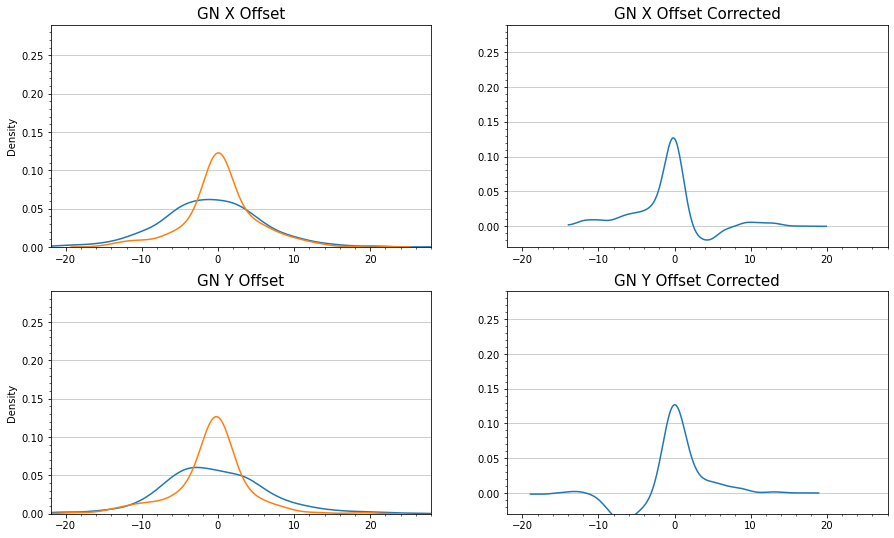

In [11]:
plt.figure(figsize=[15,9])

plt.subplot(221)
plt.grid(axis = 'y',alpha = .75)
a = sea.distplot(x_off_rand,hist = False)
b = sea.distplot(x_offset,hist = False)
plt.xlim(-22, 28)
plt.ylim(0, .29)
plt.minorticks_on()
plt.title("GN X Offset", fontsize = 15)

plt.subplot(222)
plt.grid(axis = 'y',alpha = .75)
data_x = func.Get_posterior(np.array(x_offset))
rand_x = func.Get_posterior(np.array(x_off_rand))
corrected_x = data_x[1] - rand_x[1]
plt.plot(data_x[0],corrected_x)
plt.xlim(-22, 28)
plt.ylim(-.03, .29)
plt.minorticks_on()
plt.title("GN X Offset Corrected", fontsize = 15)

plt.subplot(223)
plt.grid(axis = 'y',alpha = .75)
a = sea.distplot(y_off_rand,hist = False)
b = sea.distplot(y_offset,hist = False)
plt.xlim(-22, 28)
plt.ylim(0, .29)
plt.minorticks_on()
plt.title("GN Y Offset", fontsize = 15)

plt.subplot(224)
plt.grid(axis = 'y',alpha = .75)
data_y = func.Get_posterior(np.array(y_offset))
rand_y = func.Get_posterior(np.array(y_off_rand))
corrected_y = data_y[1] - rand_y[1]
plt.plot(data_y[0],corrected_y)
plt.xlim(-22, 28)
plt.ylim(-.03, .29)
plt.minorticks_on()
plt.title("GN Y Offset Corrected", fontsize = 15)

/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/felix/anaconda3/envs/grizli/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'GN Y Offset')

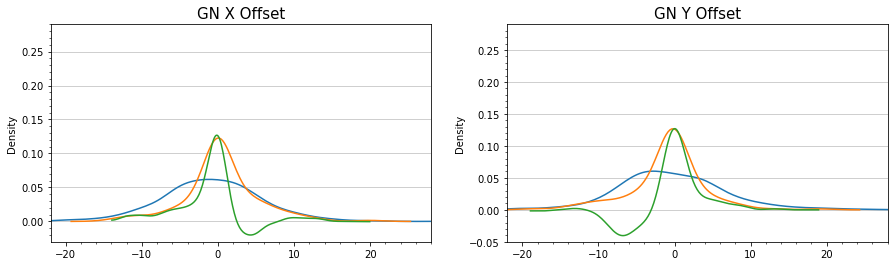

In [12]:
plt.figure(figsize=[15,4])

plt.subplot(121)
plt.grid(axis = 'y',alpha = .75)
a = sea.distplot(x_off_rand,hist = False)
b = sea.distplot(x_offset,hist = False)
data_x = func.Get_posterior(np.array(x_offset))
rand_x = func.Get_posterior(np.array(x_off_rand))
corrected_x = data_x[1] - rand_x[1]
plt.plot(data_x[0],corrected_x)
plt.xlim(-22, 28)
plt.ylim(-.03, .29)
plt.minorticks_on()
plt.title("GN X Offset", fontsize = 15)

plt.subplot(122)
plt.grid(axis = 'y',alpha = .75)
a = sea.distplot(y_off_rand,hist = False)
b = sea.distplot(y_offset,hist = False)
data_y = func.Get_posterior(np.array(y_offset))
rand_y = func.Get_posterior(np.array(y_off_rand))
corrected_x = data_y[1] - rand_y[1]
plt.plot(data_y[0],corrected_y)
plt.xlim(-22, 28)
plt.ylim(-.05, .29)
plt.minorticks_on()
plt.title("GN Y Offset", fontsize = 15)

#Orange is the real data
#Blue is the randomized data
#Green is the 'corrected' data

Normalizing the curves:

Text(0.5, 1.0, 'GN Y Offset Normalized')

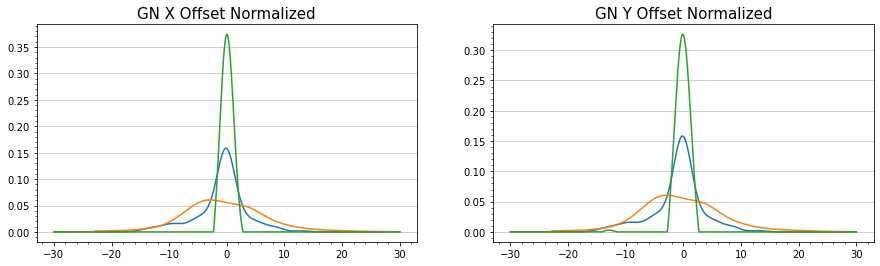

In [13]:
from scipy.interpolate import interp1d

xrange = np.linspace(-30,30, 1000)
idata = interp1d(data_x[0], data_x[1], bounds_error = False, fill_value = 0)
irand = interp1d(rand_x[0], rand_x[1], bounds_error = False, fill_value = 0)
corrected_x = idata(xrange) - irand(xrange)
corrected_x[corrected_x < 0] = 0

yrange = np.linspace(-30,30, 1000)
idata = interp1d(data_y[0], data_y[1], bounds_error = False, fill_value = 0)
irand = interp1d(rand_y[0], rand_y[1], bounds_error = False, fill_value = 0)
corrected_y = idata(yrange) - irand(yrange)
corrected_y[corrected_y < 0] = 0

plt.figure(figsize=[15,4])

plt.subplot(121)
plt.minorticks_on()
plt.grid(axis = 'y',alpha = .75)
plt.plot(xrange, idata(xrange))
plt.plot(xrange, irand(xrange))
plt.plot(xrange, corrected_x / np.trapz(corrected_x,xrange))
plt.title("GN X Offset Normalized", fontsize = 15)

plt.subplot(122)
plt.minorticks_on()
plt.grid(axis = 'y',alpha = .75)
plt.plot(yrange, idata(yrange))
plt.plot(yrange, irand(yrange))
plt.plot(yrange, corrected_y / np.trapz(corrected_y,xrange))
plt.title("GN Y Offset Normalized", fontsize = 15)

Saving our corrected x and y curves

In [35]:
#np.save(Ha_path+'corrected_x_median.npy', corrected_x)
#np.save(Ha_path+'corrected_y_median.npy', corrected_y)